# 10. 프로젝트: 더 멋진 번역기 만들기

## 목차
1. 프로젝트 개요
    - (1) NLP 분야에서 트랜스포머
    - (2) 평가 항목
2. 필요 모듈 불러오기
3. 데이터 다운로드
4. 데이터 정제 및 토큰화
    - (1) 중복 데이터 제거
    - (2) 정제 함수 정의
    - (3) 토큰화
    - (4) 토큰 길이 50 이하 데이터 선별
5. 모델 설계
    - (1) Positional Encoding
    - (2) Multi-Head Attention
    - (3) Position-wise Feed-Forward Network
    - (4) Encoder Layer
    - (5) Decoder Layer
    - (6) Encoder
    - (7) Decoder
    - (8) Transformer
    - (9) Masking
6. 훈련하기

## 1. 프로젝트 개요

### (1) NLP 분야에서 트랜스포머
- 트랜스포머는 현재까지도 각종 번역 부문에서 최고의 성능을 자랑하는 모델
- 트랜스포머로 번역기 만들어보기
- 트랜스포머 모델은 NLP 분야에서는 어느 곳에도 빠지지 않는 가장 중요한 모델 구조의 근간이 되기 때문에, 구현 실습을 통해 트랜스포머의 구조 꼼꼼히 파악해 보기
<br>

- 트랜스포머를 완성하는 데에 필요한 모듈들을 하나씩 만든 후, 조립하여 완성하는 방식으로 진행
<br>

- Tensor로 변환된 입력 데이터가 주어졌다고 가정하고 흐름을 생각해 보기
- 최초의 텍스트 입력 데이터는 \[batch_size x length\]의 형태를 가지고 있음
- 번역이 끝나고 난 최종 출력 데이터는 \[batch_size x length x vocab_size\]의 형태를 가지게 됨
- 번역 문제는 결국 매 스텝마다 'vocab_size' 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 'length'만큼 반복하는 것
- 모델 구성하는 과정에서 레이어를 통과할 때마다 텐서의 shape가 어떻게 바뀌는지 눈여겨보기

=====================================================================================================================================
- 1. 입력 데이터 -> \[batch_size x length\]
- 2. Source & Target Embedding -> \[batch_size x length x d_emb\]
- 3. **Positional Encoding** 강의 노드에서 구현. 2번의 결과에 더해지므로 shape 변화는 없음
- 4. **Multi-Head Attention** 아래와 같이 여러 개의 서브 모듈들이 존재
    - 1) **Split Heads** -> \[batch_size x length x heads x (d_emb / n_heads)\]
    - 2) **Masking for Masked Attention**
    - 3) **Scaled Dot Product Attention**
    - 4) **Combine Heads** -> \[batch_size x length x d_emb\]
- 5. Residual Connection
- 6. Layer Normalization
- 7. **Position-wise Feed-Forward Network** -> \[batch_size x length x d_ff\]
- 8. Output Linear Layer -> \[batch_size x length x vocab_size\]

=====================================================================================================================================

- **굵게** 표시된 모듈을 제외하면 나머지는 텐서플로우 내부에 이미 구현체가 포함되어 있어서 간단하게 사용할 수 있음

### (2) 평가 항목
|평가문항|상세기준|
|---|---|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어짐|데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행됨|
|2. Transformer 번역기 모델이 정상적으로 구동됨|Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작함|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성됨|제시된 문장에 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침함|

## 2. 필요 모듈 불러오기

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

# Attention 시각화를 위해 필요!
import seaborn 

print(tf.__version__)

2.4.1


- 한국어가 포함된 말뭉치를 사용하므로, 한국어를 잘 시각화하기 위한 준비가 필요
- 다만 'matplotlib' 라이브러리의 기본 폰트는 한국어를 지원하지 않음
- 올바른 Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경해 주기
<br>

- 아직 컴퓨터에 글꼴이 설치되어 있지 않다면, 터미널에서 나눔 글꼴을 설치
- ```python
$ sudo apt -qq -y install fonts-nanum
```
- 아래 코드를 실행
- 앞으로 필요한 경우 한글을 실행해야 할 때 미리 한 번씩 실행해 주기

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname = fontpath, size=9)
plt.rc('font', family ='NanumBarunGothic') 
mpl.font_manager._rebuild()

## 3. 데이터 다운로드

- 아래 링크에서'korean-english-park.train.tar.gz'를 사용할 예정
- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
- 클라우드 환경에서는 데이터를 미리 준비해 놓았으니 연결만 시켜주기
- 아래와 같이 공유 디렉토리에 저장된 데이터를 가리키는 심볼릭 링크를 생성
```python
$ ln -s ~/data ~/aiffel/transformer/data
```

## 4. 데이터 정제 및 토큰화

### (1) 중복 데이터 제거
- 'set' 데이터형이 **중복을 허용하지 않는다는 것을 활용**해 중복된 데이터를 제거
- 데이터의 **병렬 쌍이 흐트러지지 않게 주의**
- 중복을 제거한 데이터를 'cleaned_corpus'에 저장

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    # 중복 데이터 제거
    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

### (2) 정제 함수 정의
- 정제 함수를 아래 조건을 만족하게 정의
    - 모든 입력을 소문자로 변환
    - 알파벳, 문장부호, 한글만 남기고 모두 제거
    - 문장부호 앙옆에 공백을 추가
    - 문장 앞뒤의 불필요한 공백을 제거

In [4]:
def preprocess_sentence(sentence):
    # 모든 입력을 소문자로 변환
    sentence = sentence.lower()
    # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"[^a-zA-Z가-힣?.!,]+", " ", sentence)
    # 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 문장 앞뒤의 불필요한 공백 제거
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence

### (3) 토큰화
- 한글 말뭉치 'kor_corpus'와 영문 말뭉치 'eng_corpus'를 각각 분리한 후, 정제하여 **토큰화** 진행
- 토큰화에는 Sentencepiece를 활용
- 첨부된 공식 사이트 참고해 아래 조건을 만족하는 'generate_tokenizer()' 함수를 정의
- 최종적으로 'ko_tokenizer'과 'en_tokenizer' 얻기
- 'en_tokenizer'에는 'set_encode_extra_options("bos:eos")함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 함
- [google/sentencepiece](https://github.com/google/sentencepiece)
    

In [5]:
def generate_tokenizer(corpus, 
                       vocab_size, 
                       lang="ko", 
                       pad_id = 0, 
                       bos_id = 1, 
                       eos_id = 2, 
                       unk_id = 3):
    
    # corpus를 받아 txt파일로 저장
    temp_file = os.getenv('HOME') + f'/aiffel/transformer_copy/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    # Sentencepiece를 이용해 
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')

    return tokenizer

In [6]:
cleaned_corpus[0]

('민주당 의원들은 7월말까지 이라크 주둔할 경우 전시 비용을 지원한다는 법안을 통과 시켰다.',
 'The bill, -currently being drafted by Democratic lawmakers in the House of Representatives- funds operations in Iraq until the end of July.')

In [7]:
import sentencepiece as spm
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

### (4) 토큰 길이 50 이하 데이터 선별

In [8]:
# Process 과정을 보기 위해
from tqdm.notebook import tqdm    

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)

# 패딩처리를 완료하여 학습용 데이터를 완성
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

## 5. 모델 설계

### (1) Positional Encoding

In [9]:
# pos - 단어가 위치한 Time-step(각각의 토큰의 위치정보값이며 정수값을 의미)
# d_model - 모델의 Embedding 차원 수
# i - Encoding차원의 index

def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
     # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

### (2) Multi-Head Attention

In [10]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        # Linear Layer
        self.W_q = tf.keras.layers.Dense(d_model) 
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b = True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: 
            scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis = -1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm = [0, 2, 1, 3])
        
        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm = [0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        
        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### (3) Position-wise Feed-Forward Network

In [11]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### (4) Encoder Layer

In [12]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

### (5) Decoder Layer

In [13]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### (6) Encoder

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### (7) Decoder

In [15]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### (8) Transformer

In [16]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns


### (9) Masking

In [17]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


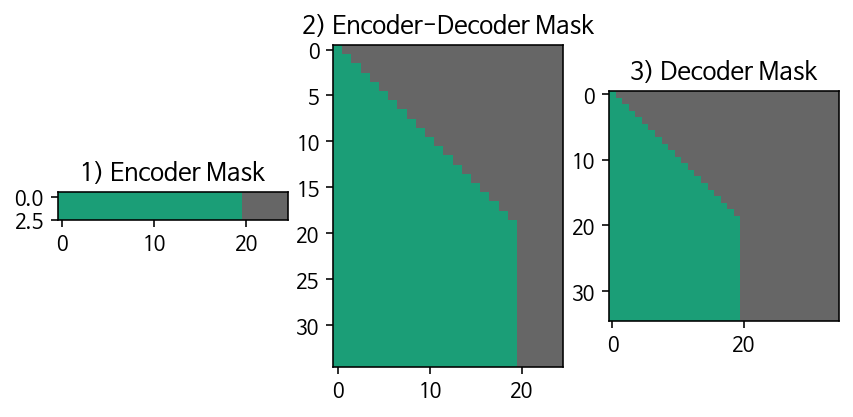

In [18]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

## 6. 훈련하기

In [32]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [33]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [21]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [1]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

NameError: name 'tf' is not defined

In [23]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [24]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        
        # InvalidArgumentError: In[0] mismatch In[1] shape: 50 vs. 1: [1,8,1,50] [1,8,1,64] 0 0 [Op:BatchMatMulV2]
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [25]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [26]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

### 1번째 학습

In [27]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

In [28]:
# 학습
EPOCHS = 20
BATCH_SIZE = 32

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx + BATCH_SIZE],
                                                                     dec_train[idx:idx + BATCH_SIZE],
                                                                     transformer,
                                                                     optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    # 매 Epoch 마다 제시된 예문에 대한 번역 생성
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s presidential hopefuls .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were part of the city s city .
Input: 커피는 필요 없다.
Predicted translation: it s not clear .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead was killed in the last weekend .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is expected to be a president of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they ve seen the best chances of the city seen the best chances of the city seen as theylum .
Input: 커피는 필요 없다.
Predicted translation: you cannot you ll find your way you need to be , you re going to do you need to be , you need to do you need to be , you need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: four people were killed and four people were killed .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president bush is taking office .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are just outside the city .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to take a necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they killed people , including the death toll .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is also a president of the world .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the city of towns in the city of towns .
Input: 커피는 필요 없다.
Predicted translation: coffee is no substitute for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in the deaths of four people .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is coming to the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city , the city s tiny cities are in the city s oldest city .
Input: 커피는 필요 없다.
Predicted translation: there needs to be no memories .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deadly wounded seven people .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is expected to be sworn in .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the fourth in the city .
Input: 커피는 필요 없다.
Predicted translation: there is no coffee for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people died saturday night .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama will pick the illinois governor .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took the olds of the city .
Input: 커피는 필요 없다.
Predicted translation: no coffee has done at its coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died saturday in the seventh place .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is expected to become the first in the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city of cities .
Input: 커피는 필요 없다.
Predicted translation: he no need to be done .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died tuesday , the seventh fatality said .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is also expected to be about .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are in the spring s neighborhood .
Input: 커피는 필요 없다.
Predicted translation: there need to be a danger .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen people died seven .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president can t say much .
Input: 시민들은 도시 속에 산다.
Predicted translation: that may spring .
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died tuesday in seven


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is about percentage points .
Input: 시민들은 도시 속에 산다.
Predicted translation: that may is the cities of the cities .
Input: 커피는 필요 없다.
Predicted translation: there is no need for rare coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven deaths occurred .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president can obama find the democratic race .
Input: 시민들은 도시 속에 산다.
Predicted translation: for the second cities in the city
Input: 커피는 필요 없다.
Predicted translation: there need to be a second night there . you need to demand there is no need to be done .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in seven seven seven seven others suffered from the seven baghdad seven buildings .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is expected to become the country s biggest .
Input: 시민들은 도시 속에 산다.
Predicted translation: for surely the city is the late night .
Input: 커피는 필요 없다.
Predicted translation: the coffee is inside .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: in seven provinces seven , seven people died in the seventh place tuesday , the ny said .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is expected to work with his wife in the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: that city comes to the nearest towns of .
Input: 커피는 필요 없다.
Predicted translation: the caffeine is immediately labeled .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died tuesday all but the casualties seven said they had been deployed .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is about two hours .
Input: 시민들은 도시 속에 산다.
Predicted translation: for the citytime , .
Input: 커피는 필요 없다.
Predicted translation: he no need to walk .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died seven seven others were wounded .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is expected to lead the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: over the city took the you astead to see the
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were seven dead on saturday .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is also picked up a private president .
Input: 시민들은 도시 속에 산다.
Predicted translation: that is the city of to use the mountain .
Input: 커피는 필요 없다.
Predicted translation: the robot is back .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died seven seven seven days later .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama will lead obama to the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: over the city of to the city
Input: 커피는 필요 없다.
Predicted translation: no need to be there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died seven seven seven others were wounded .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president can describ him as a lifelong or two president .
Input: 시민들은 도시 속에 산다.
Predicted translation: in the city that experiment , you become a return to the city .
Input: 커피는 필요 없다.
Predicted translation: the caffeine noel
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: most of the seven people died on saturday .


  0%|          | 0/2127 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is expected to get the first step in the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: that follow the most recent cities in you .
Input: 커피는 필요 없다.
Predicted translation: the robot don t need to win .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven people died and seven seven seven seven seven texas provinces remained seven seven people .


Input: 오바마는 대통령이다.
Predicted translation: president barack obama is expected to get the first step in the president .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


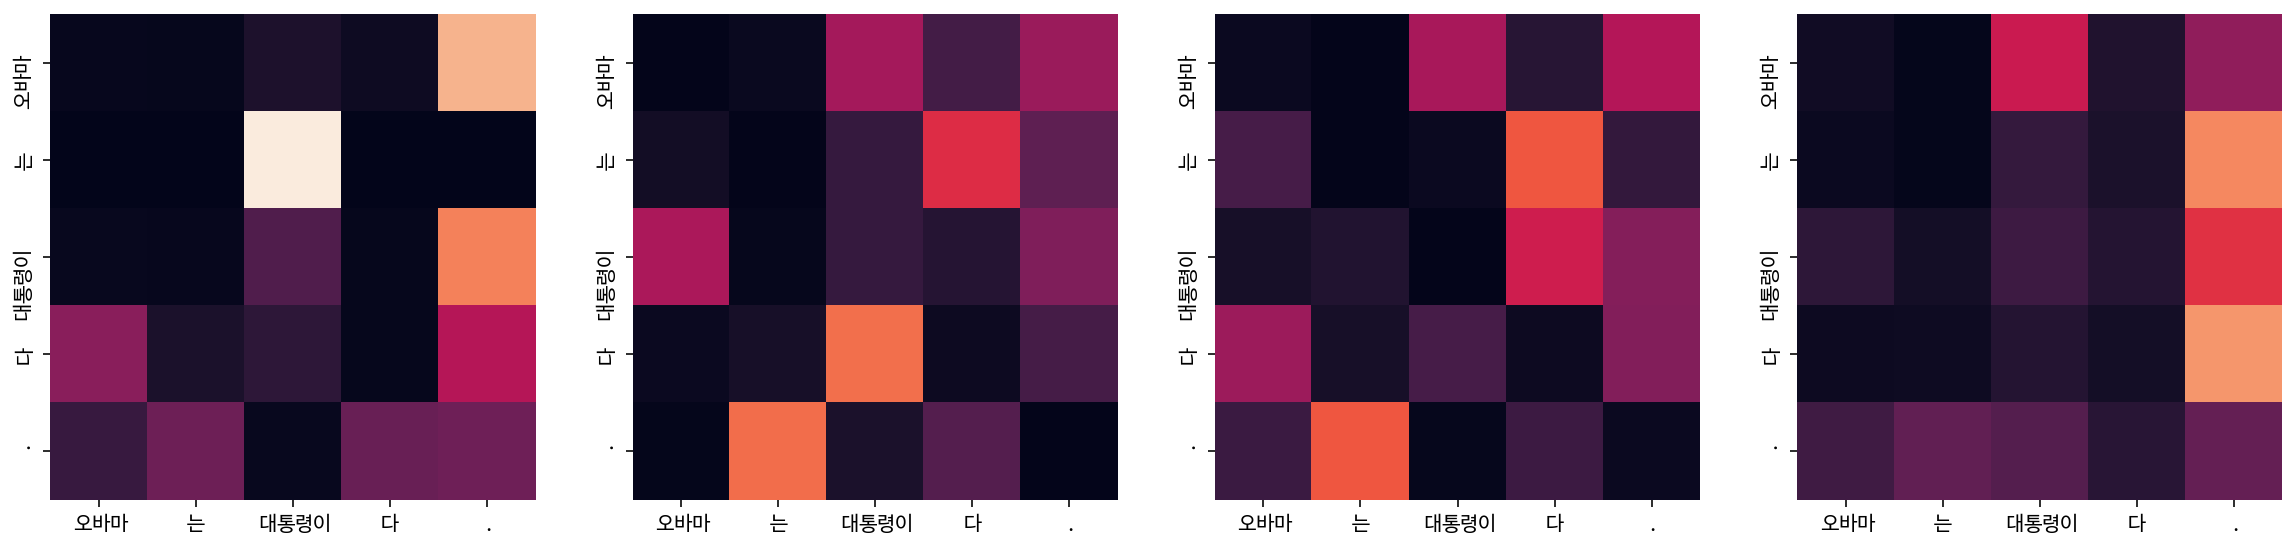

Encoder Layer 2


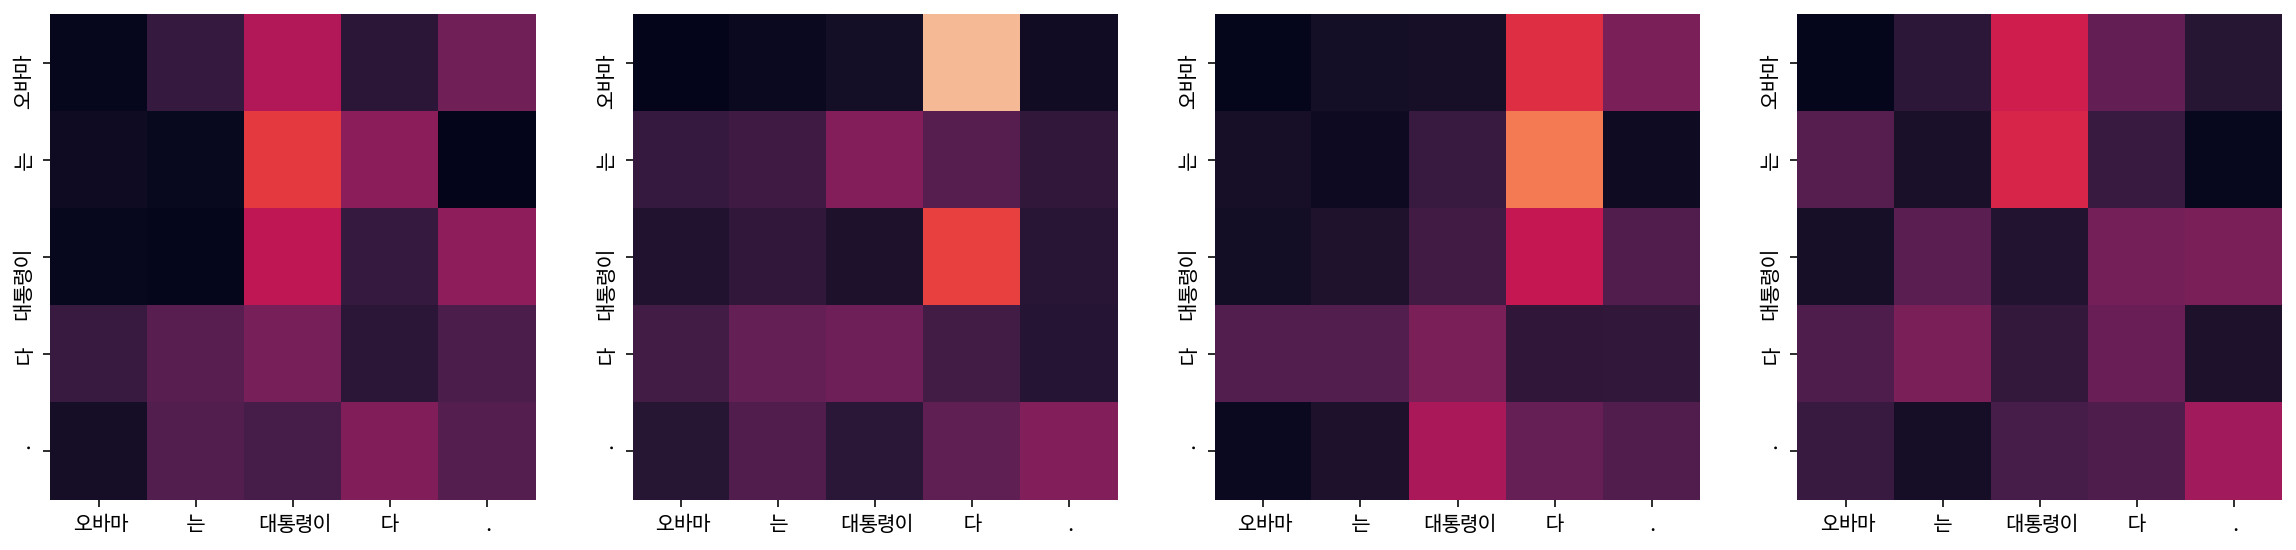

Decoder Self Layer 1


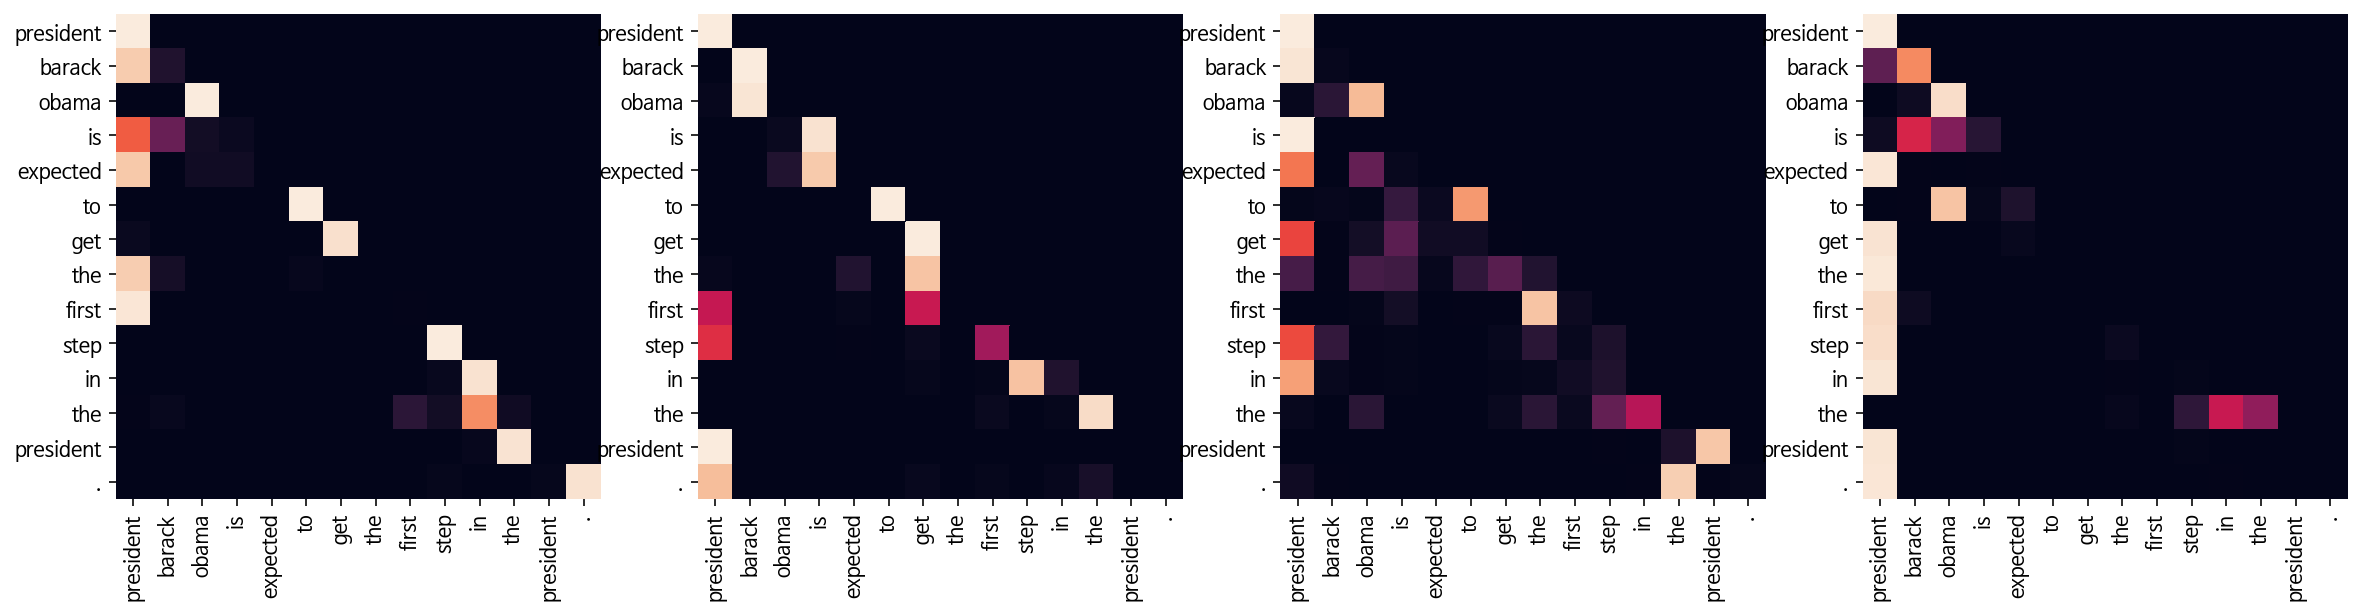

Decoder Src Layer 1


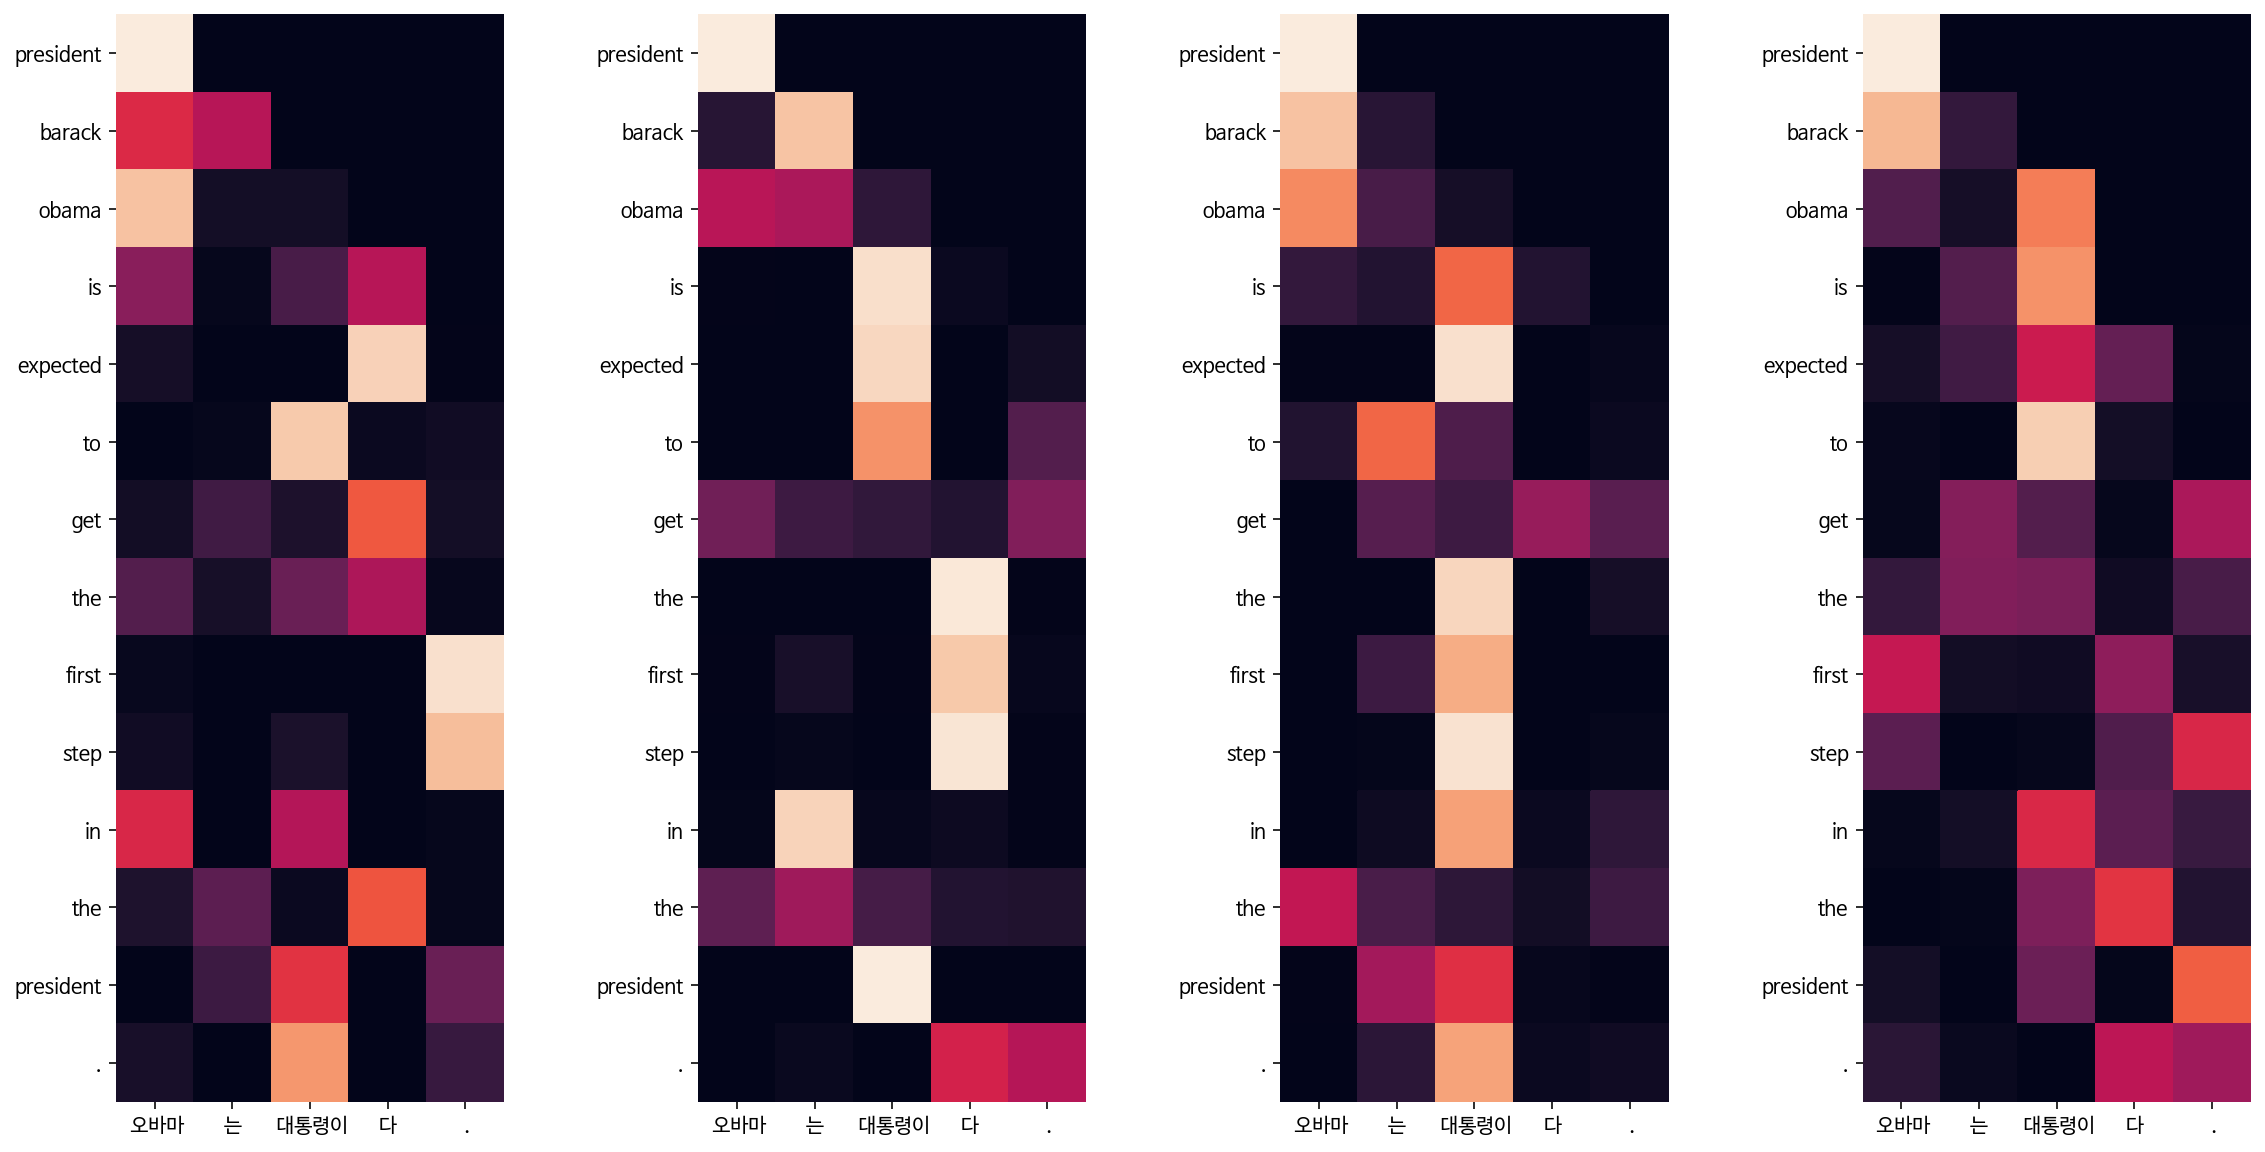

Decoder Self Layer 2


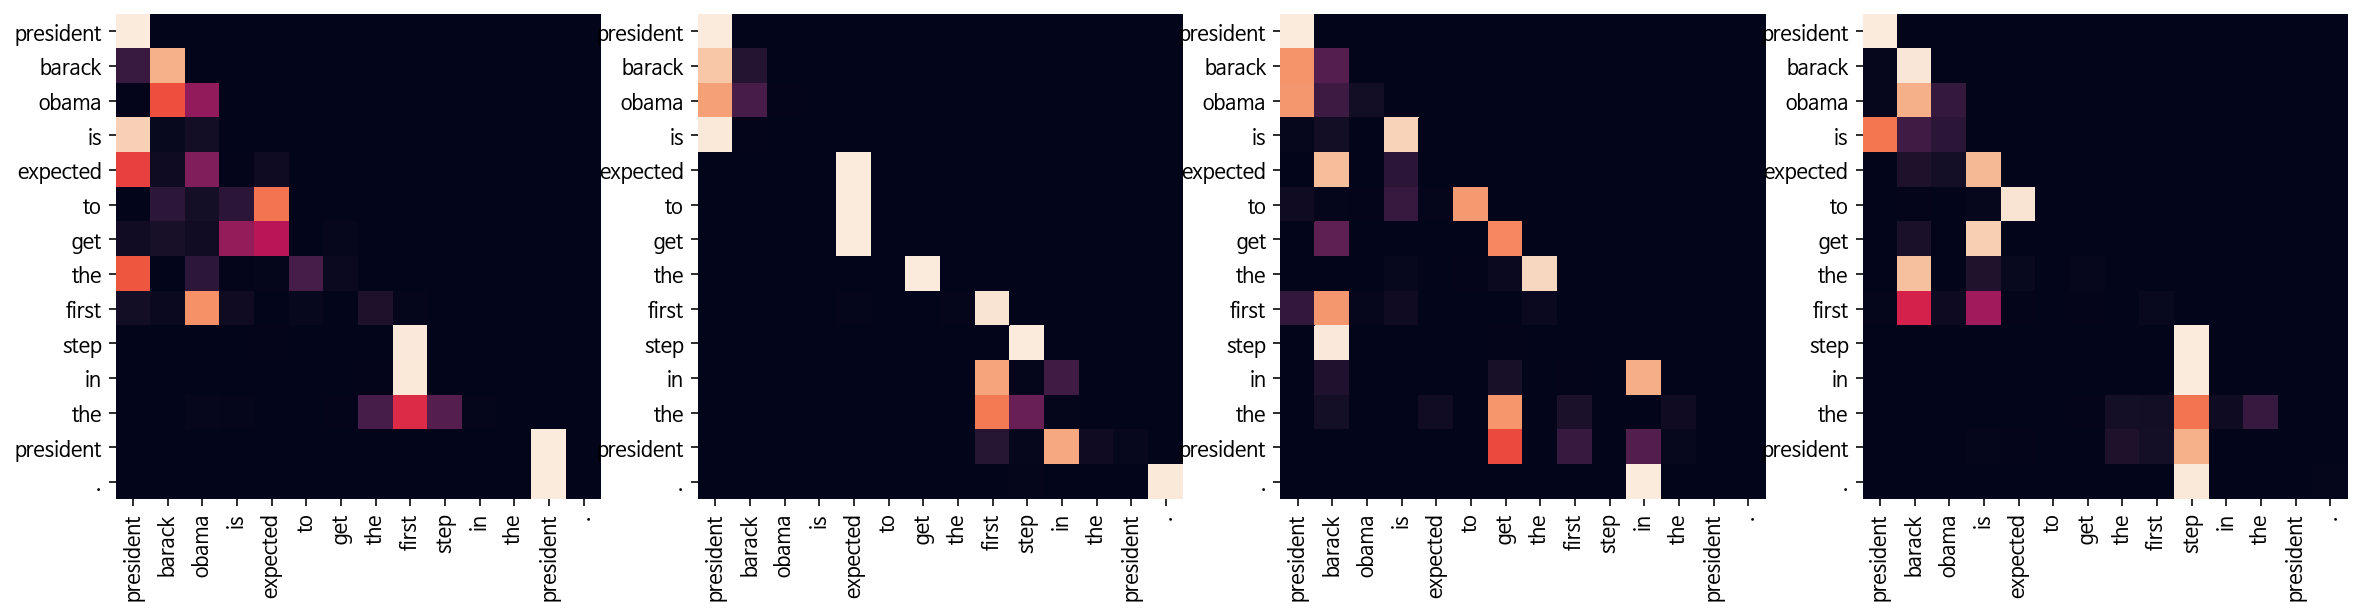

Decoder Src Layer 2


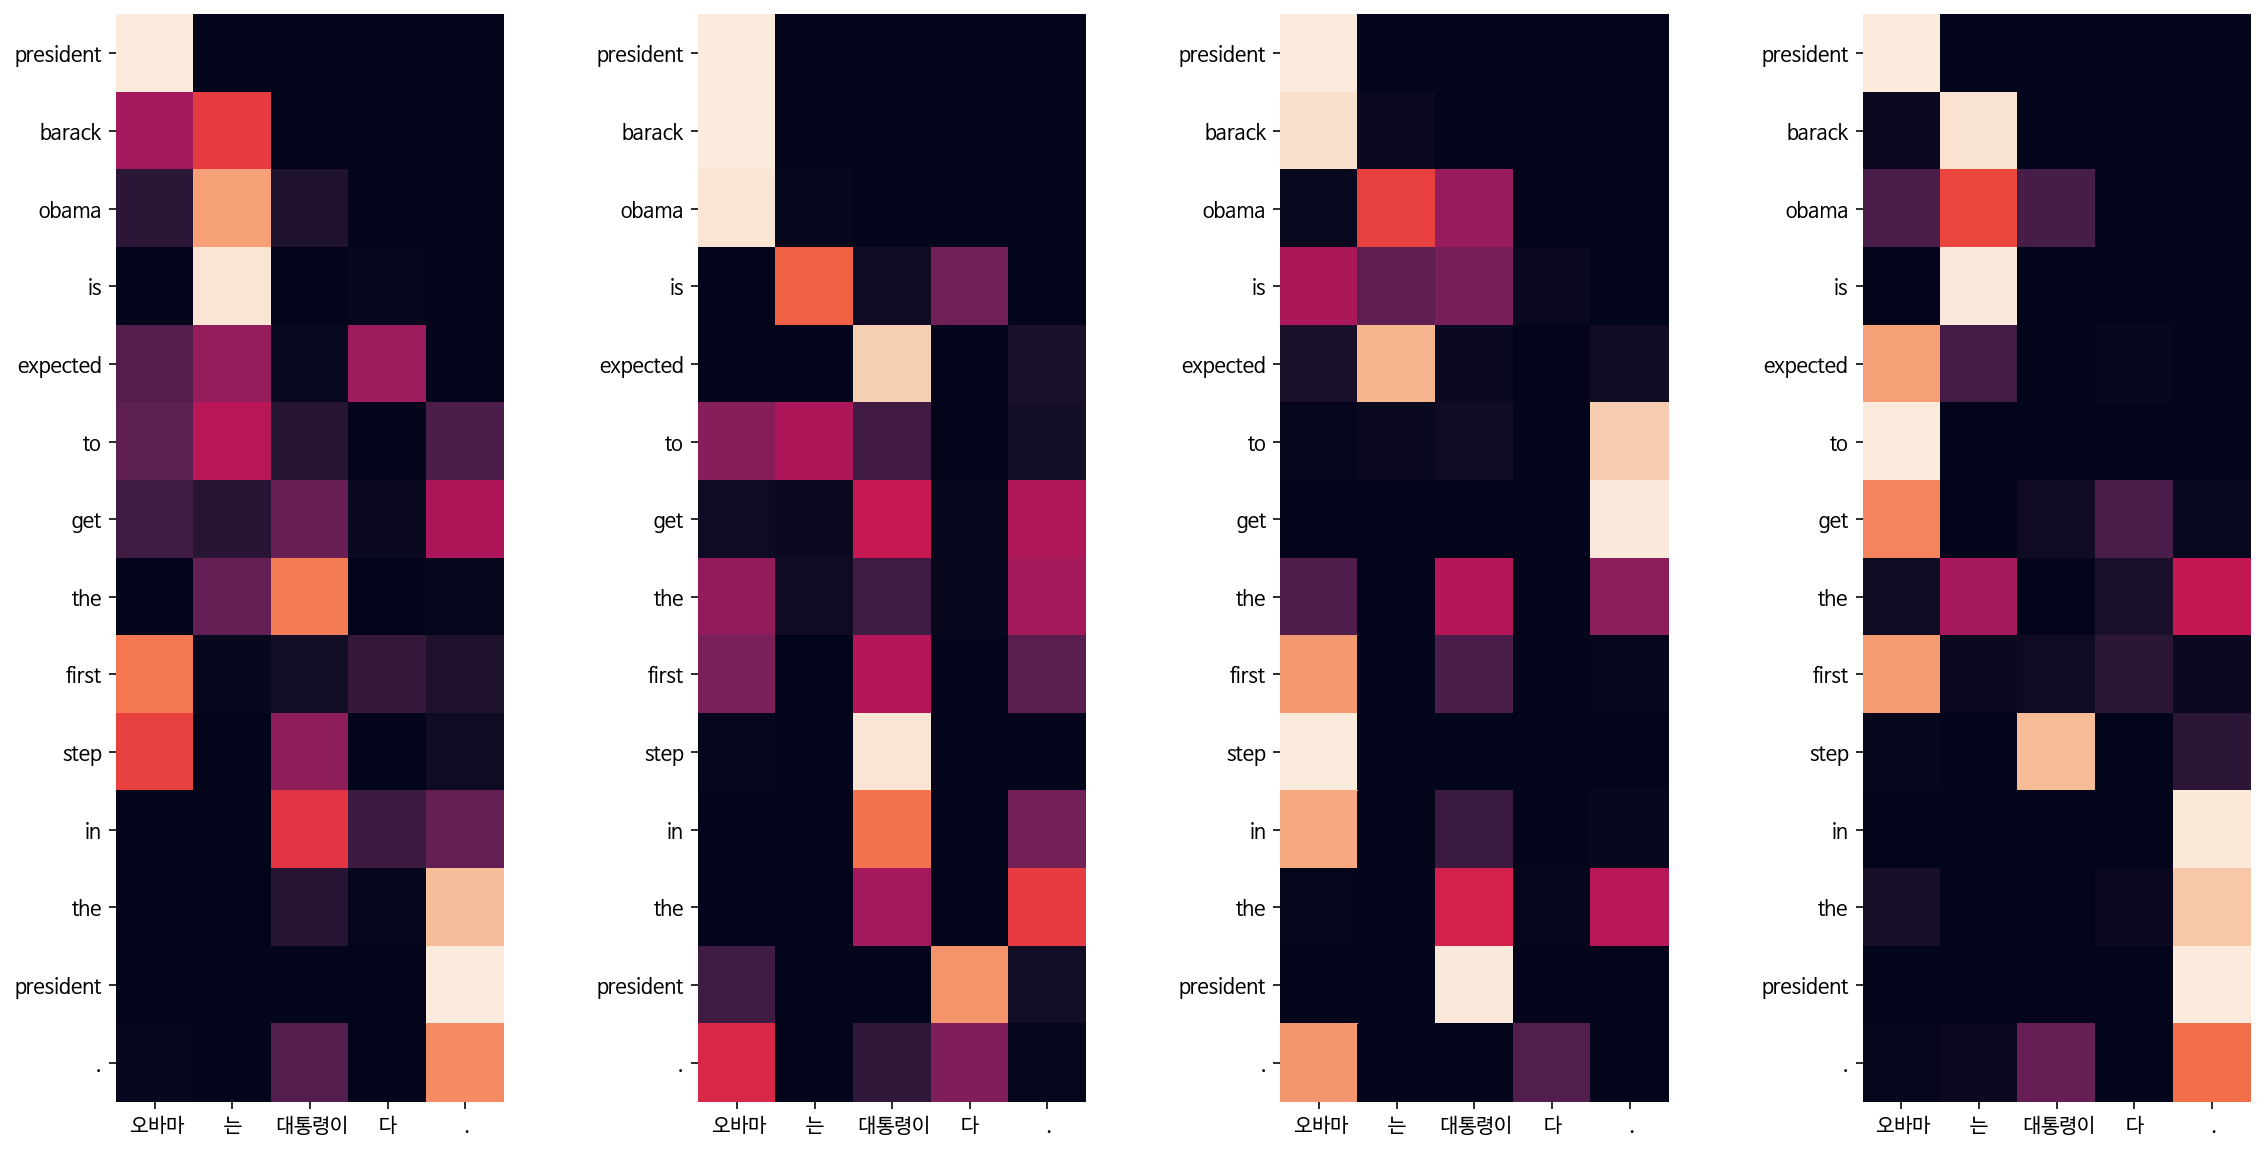

Input: 시민들은 도시 속에 산다.
Predicted translation: that follow the most recent cities in you .
Encoder Layer 1


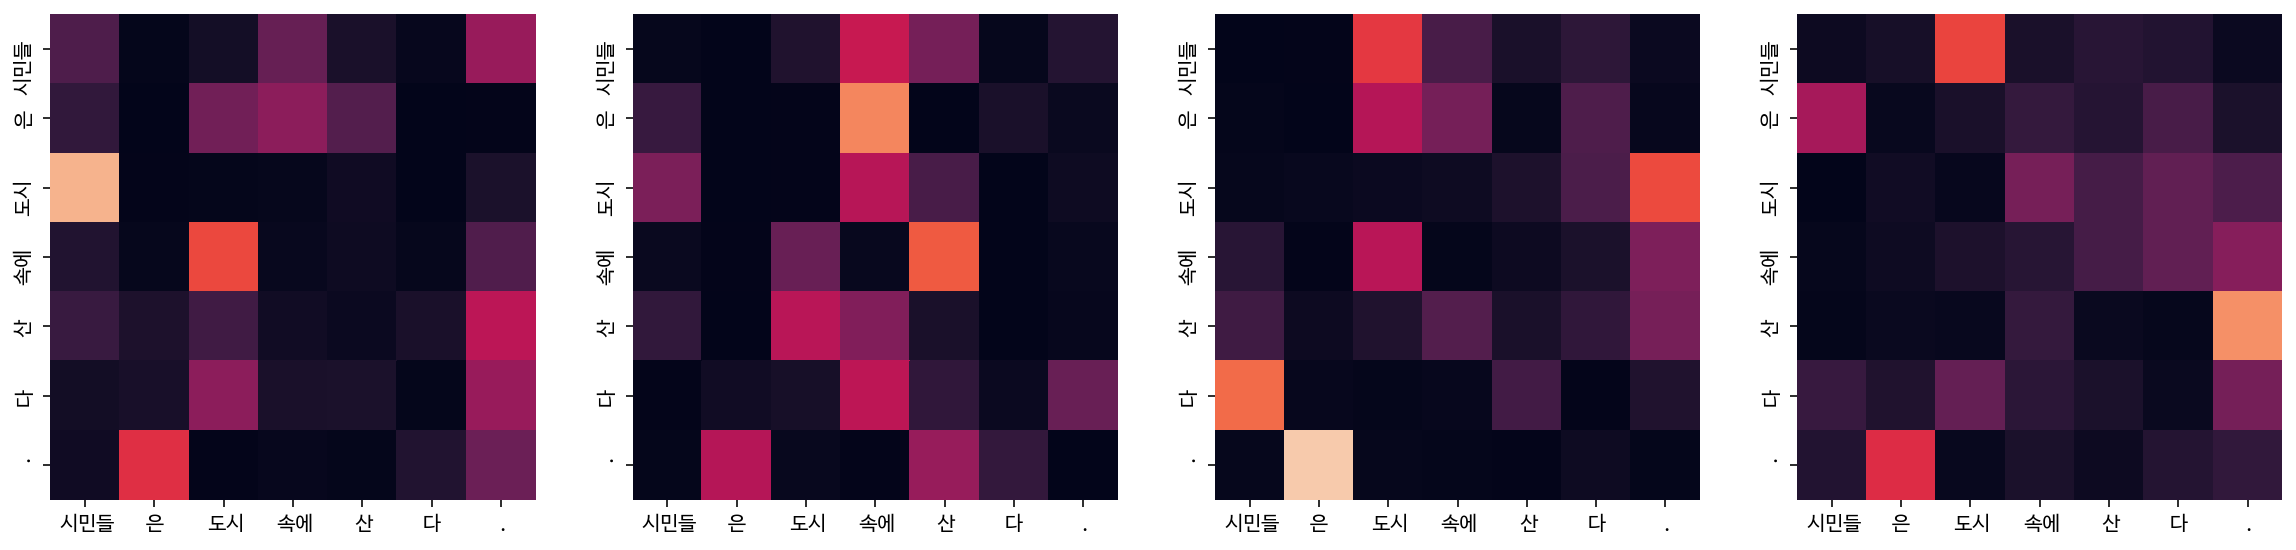

Encoder Layer 2


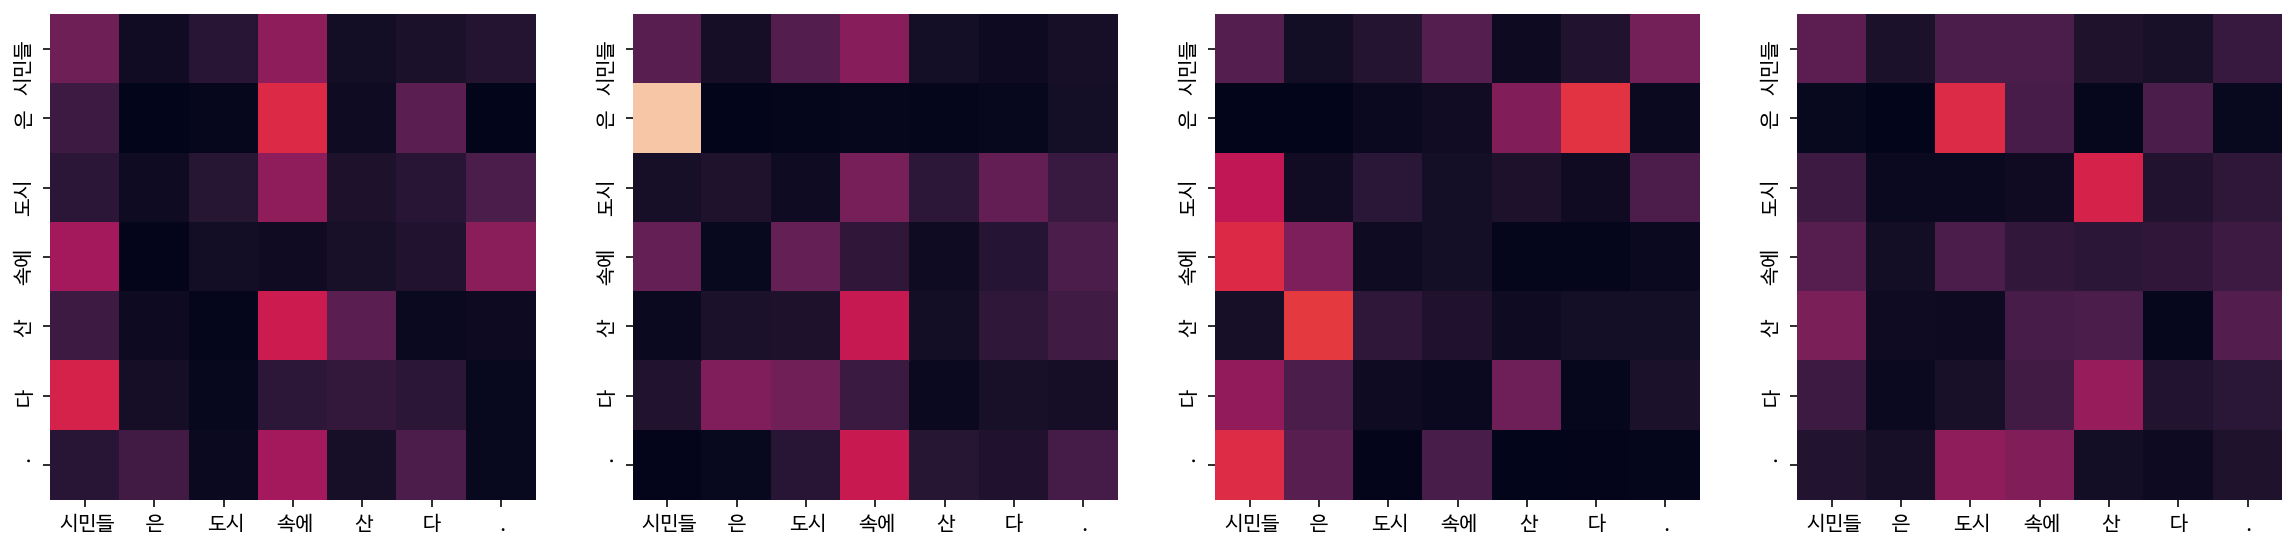

Decoder Self Layer 1


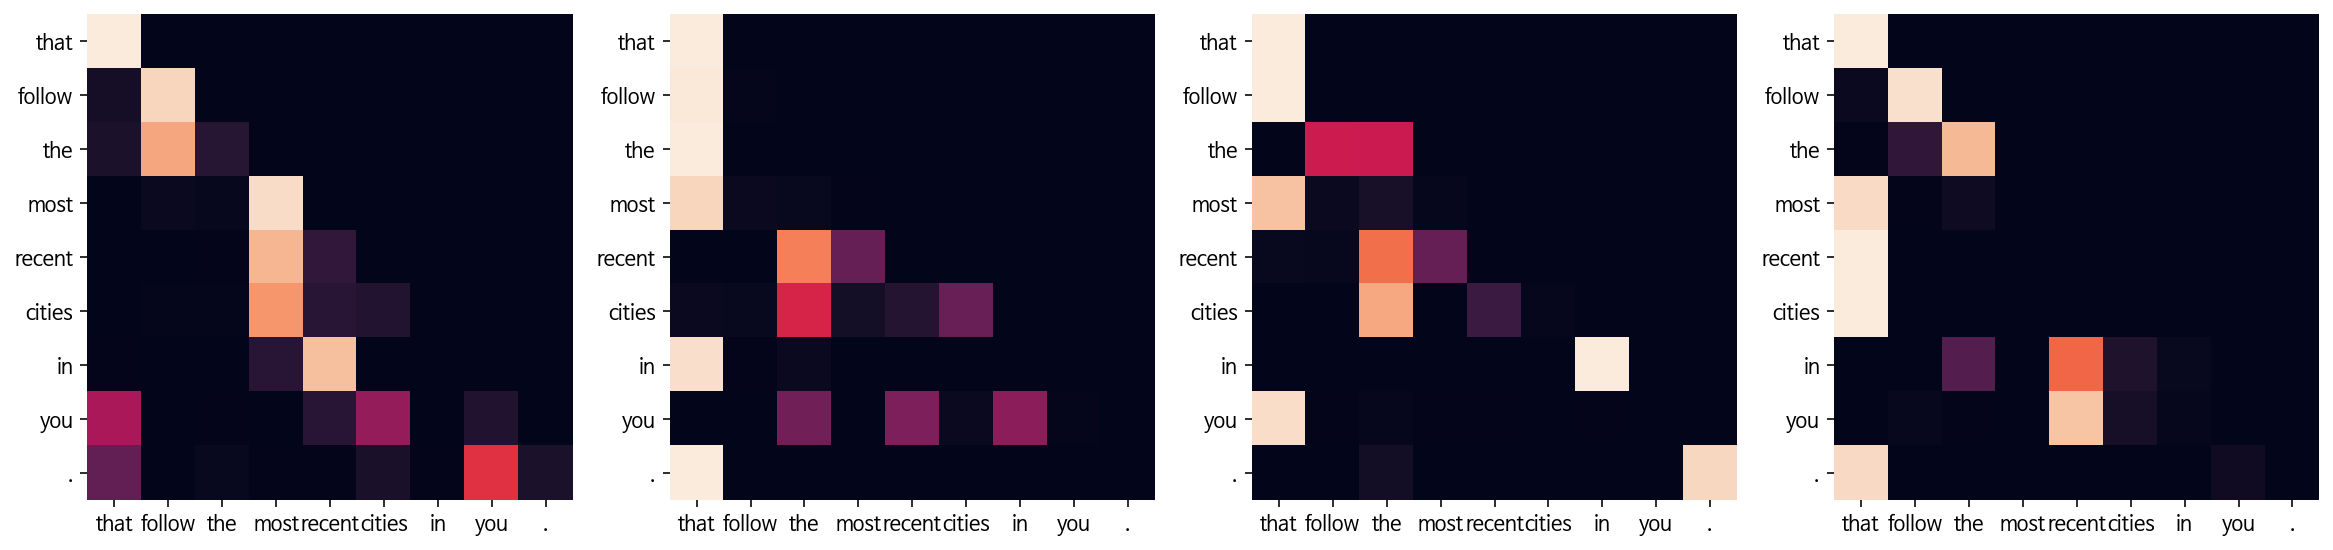

Decoder Src Layer 1


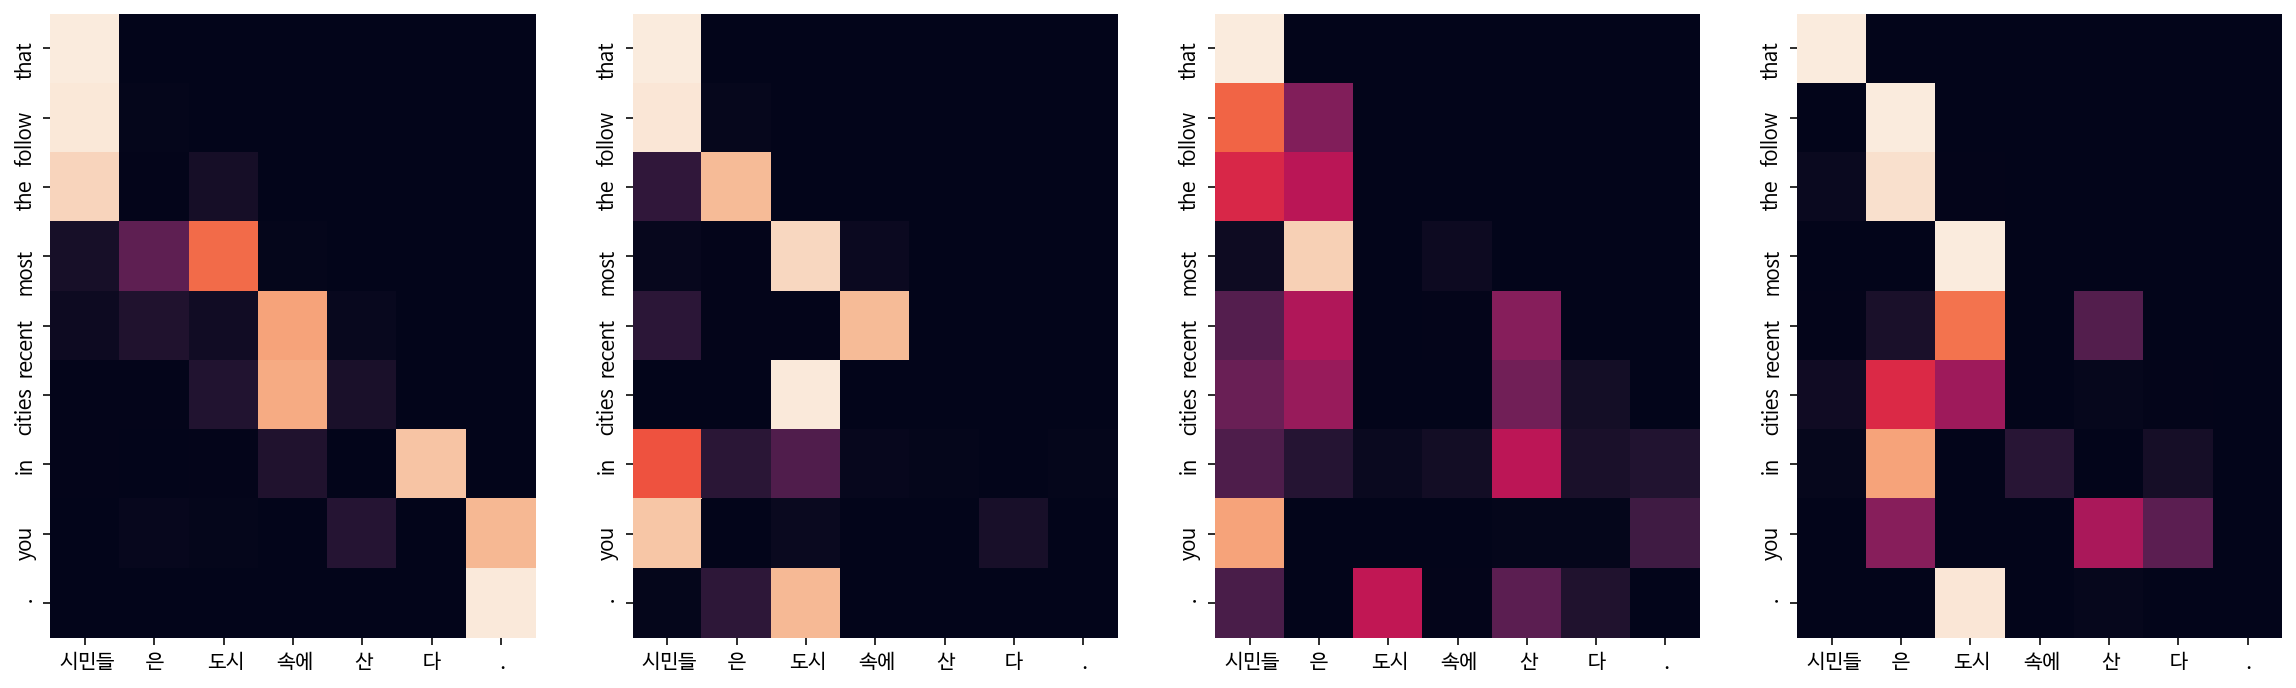

Decoder Self Layer 2


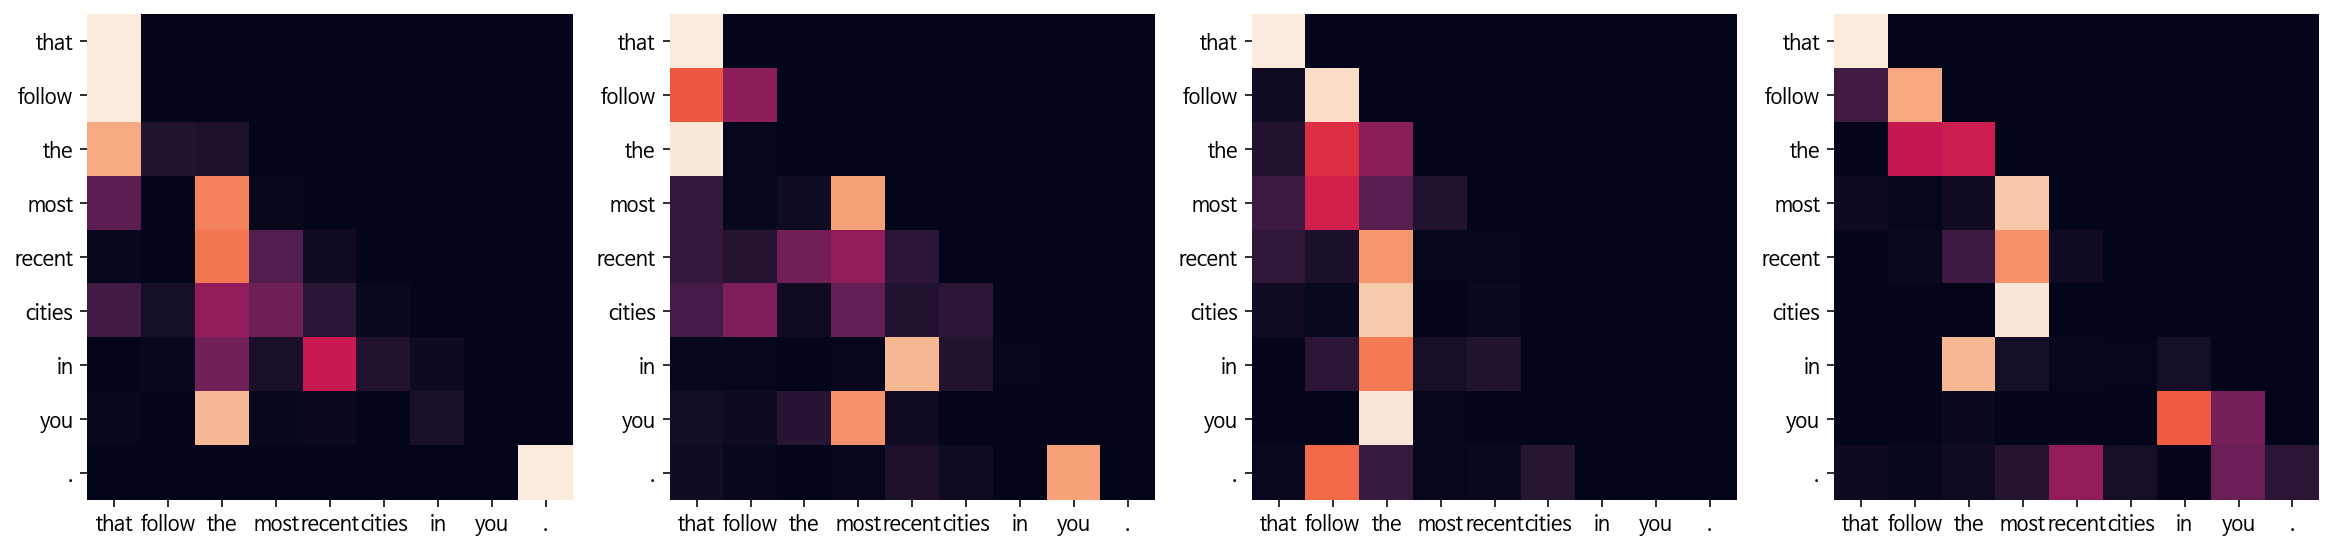

Decoder Src Layer 2


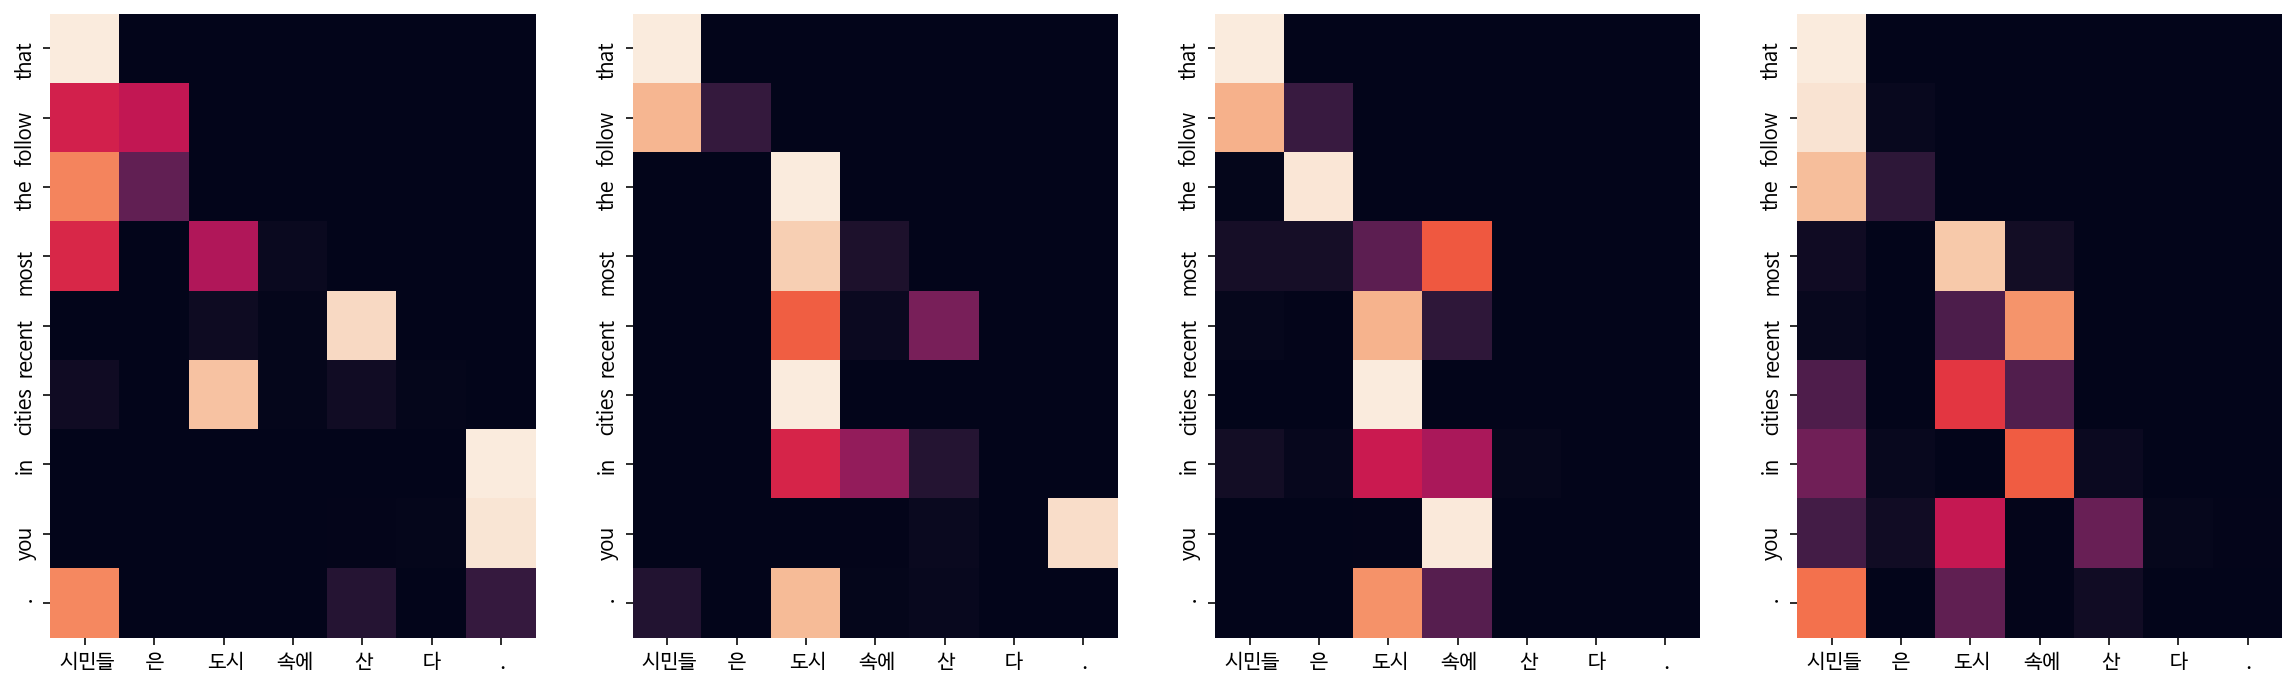

Input: 커피는 필요 없다.
Predicted translation: the robot don t need to win .
Encoder Layer 1


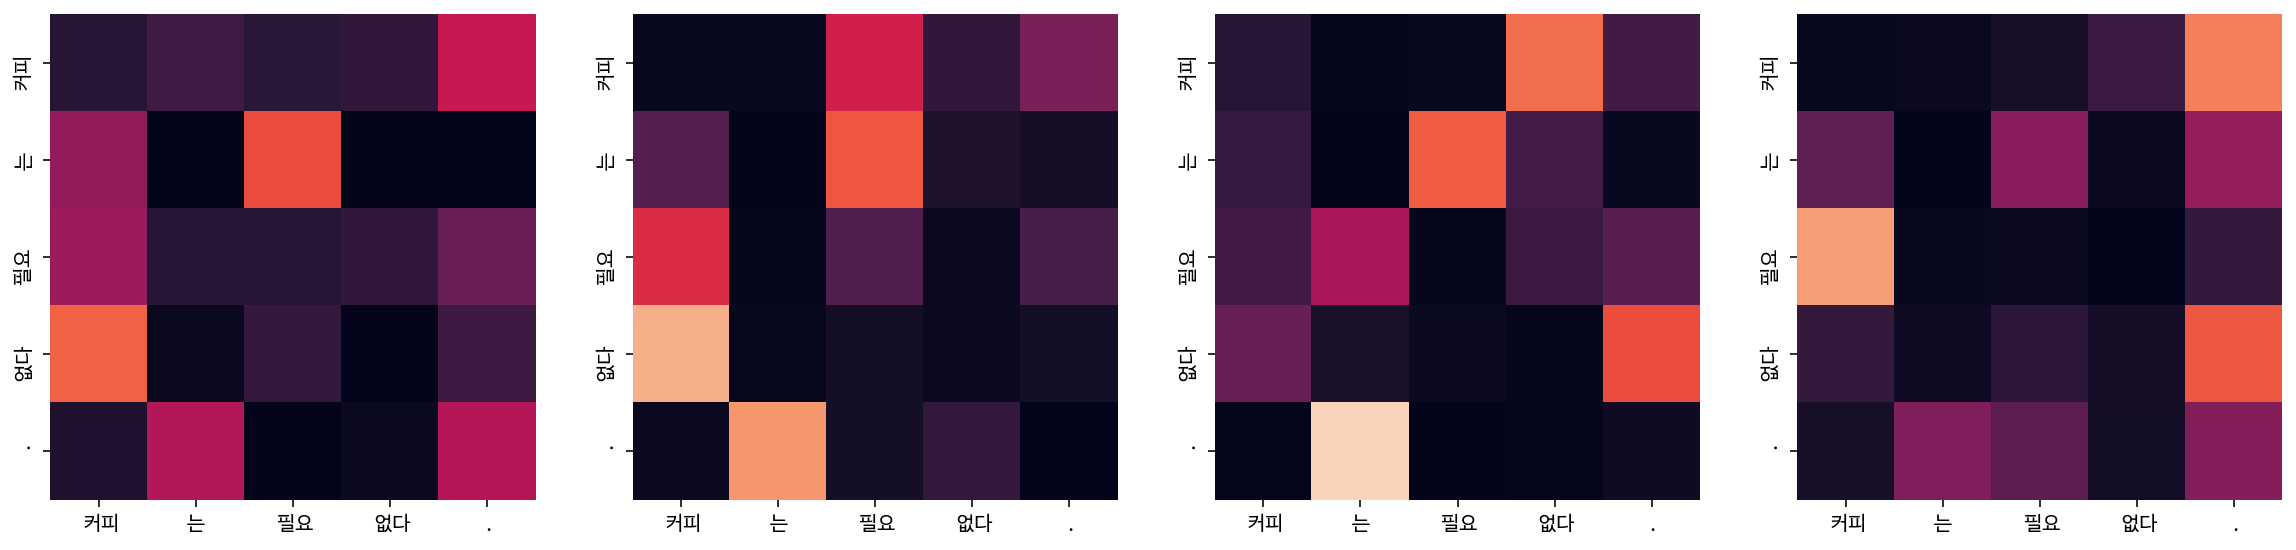

Encoder Layer 2


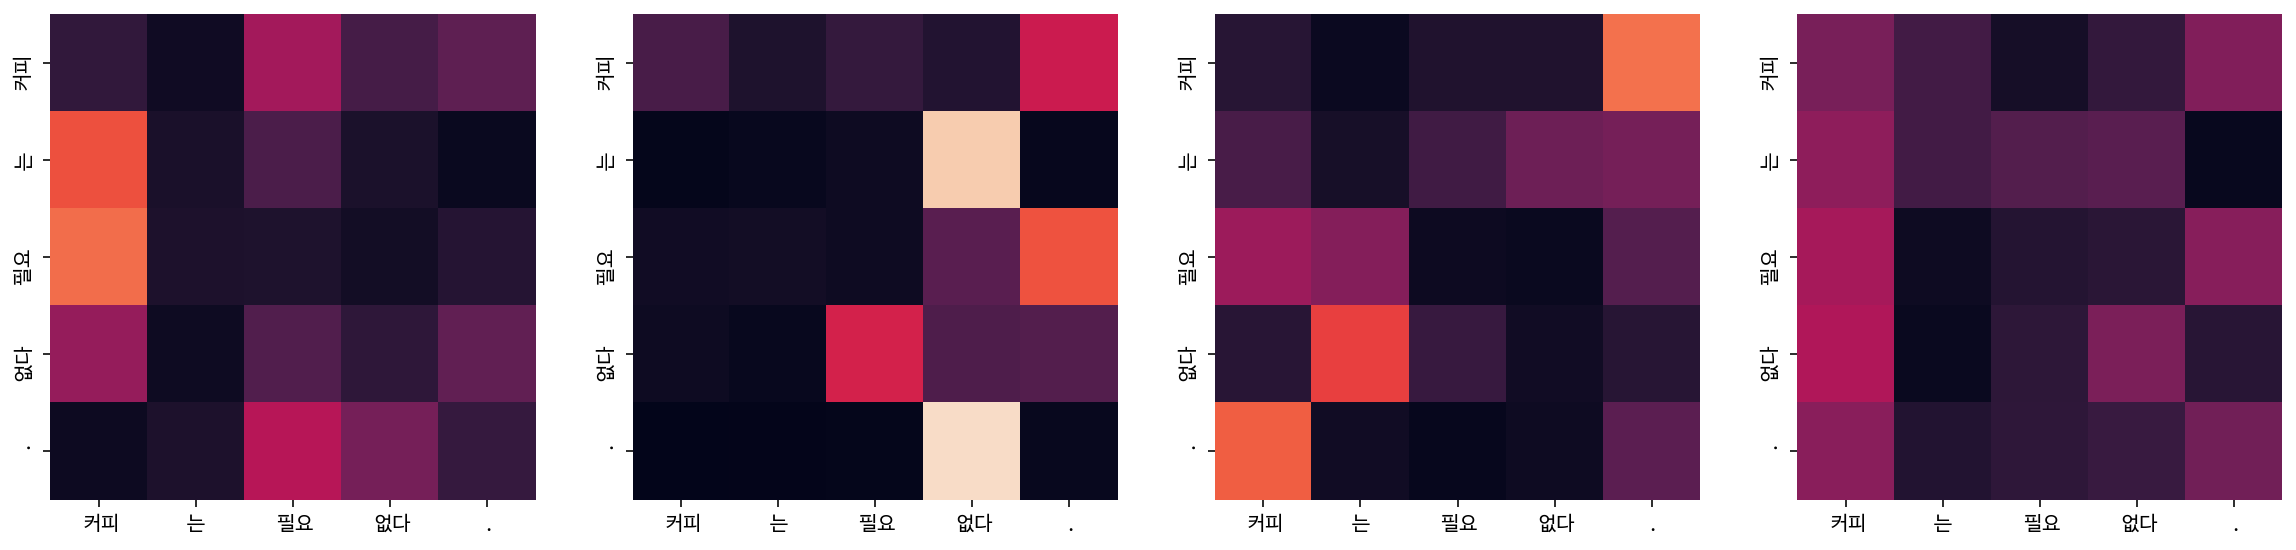

Decoder Self Layer 1


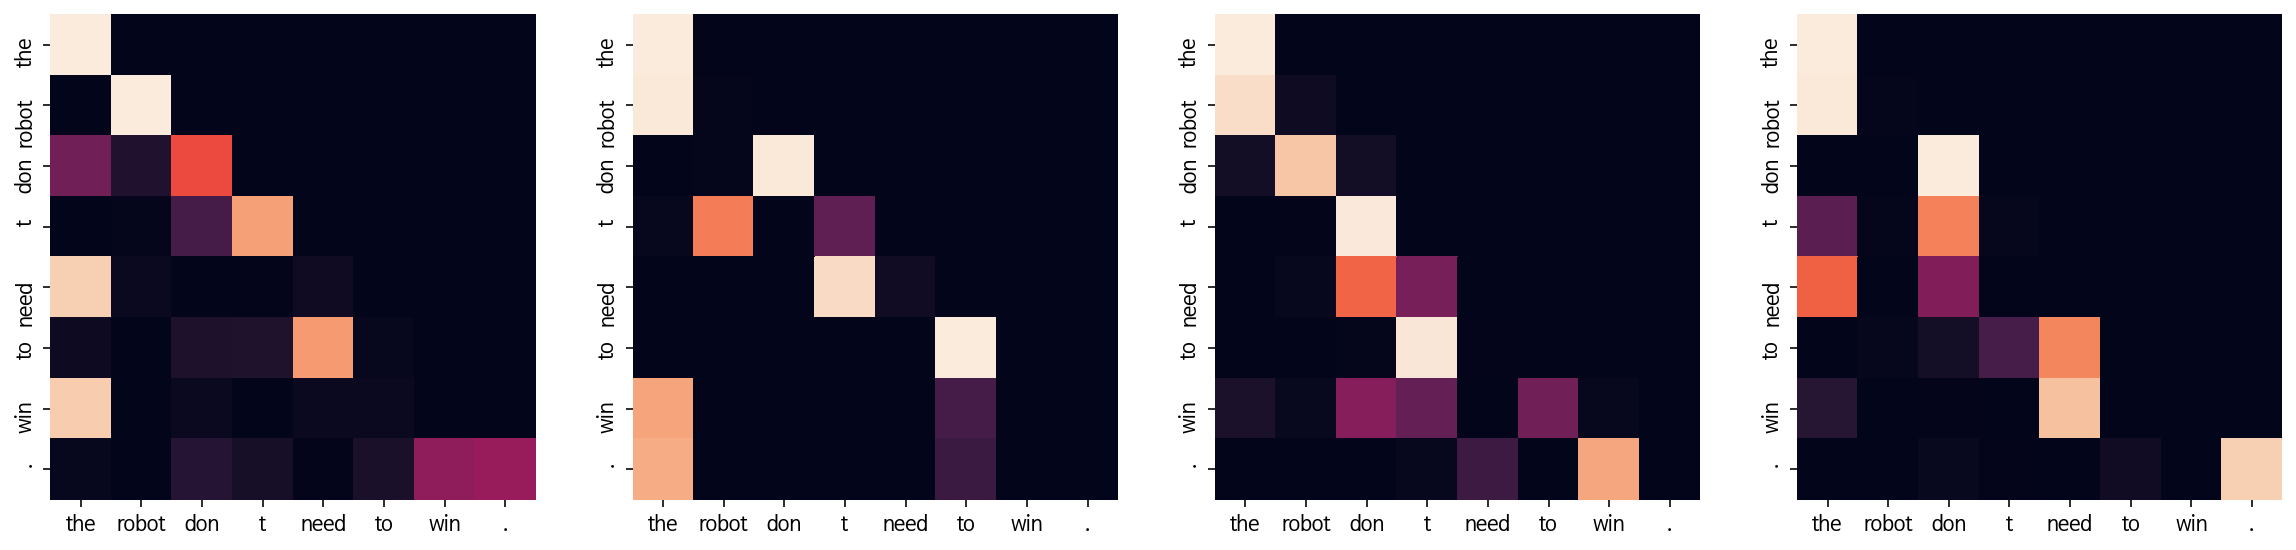

Decoder Src Layer 1


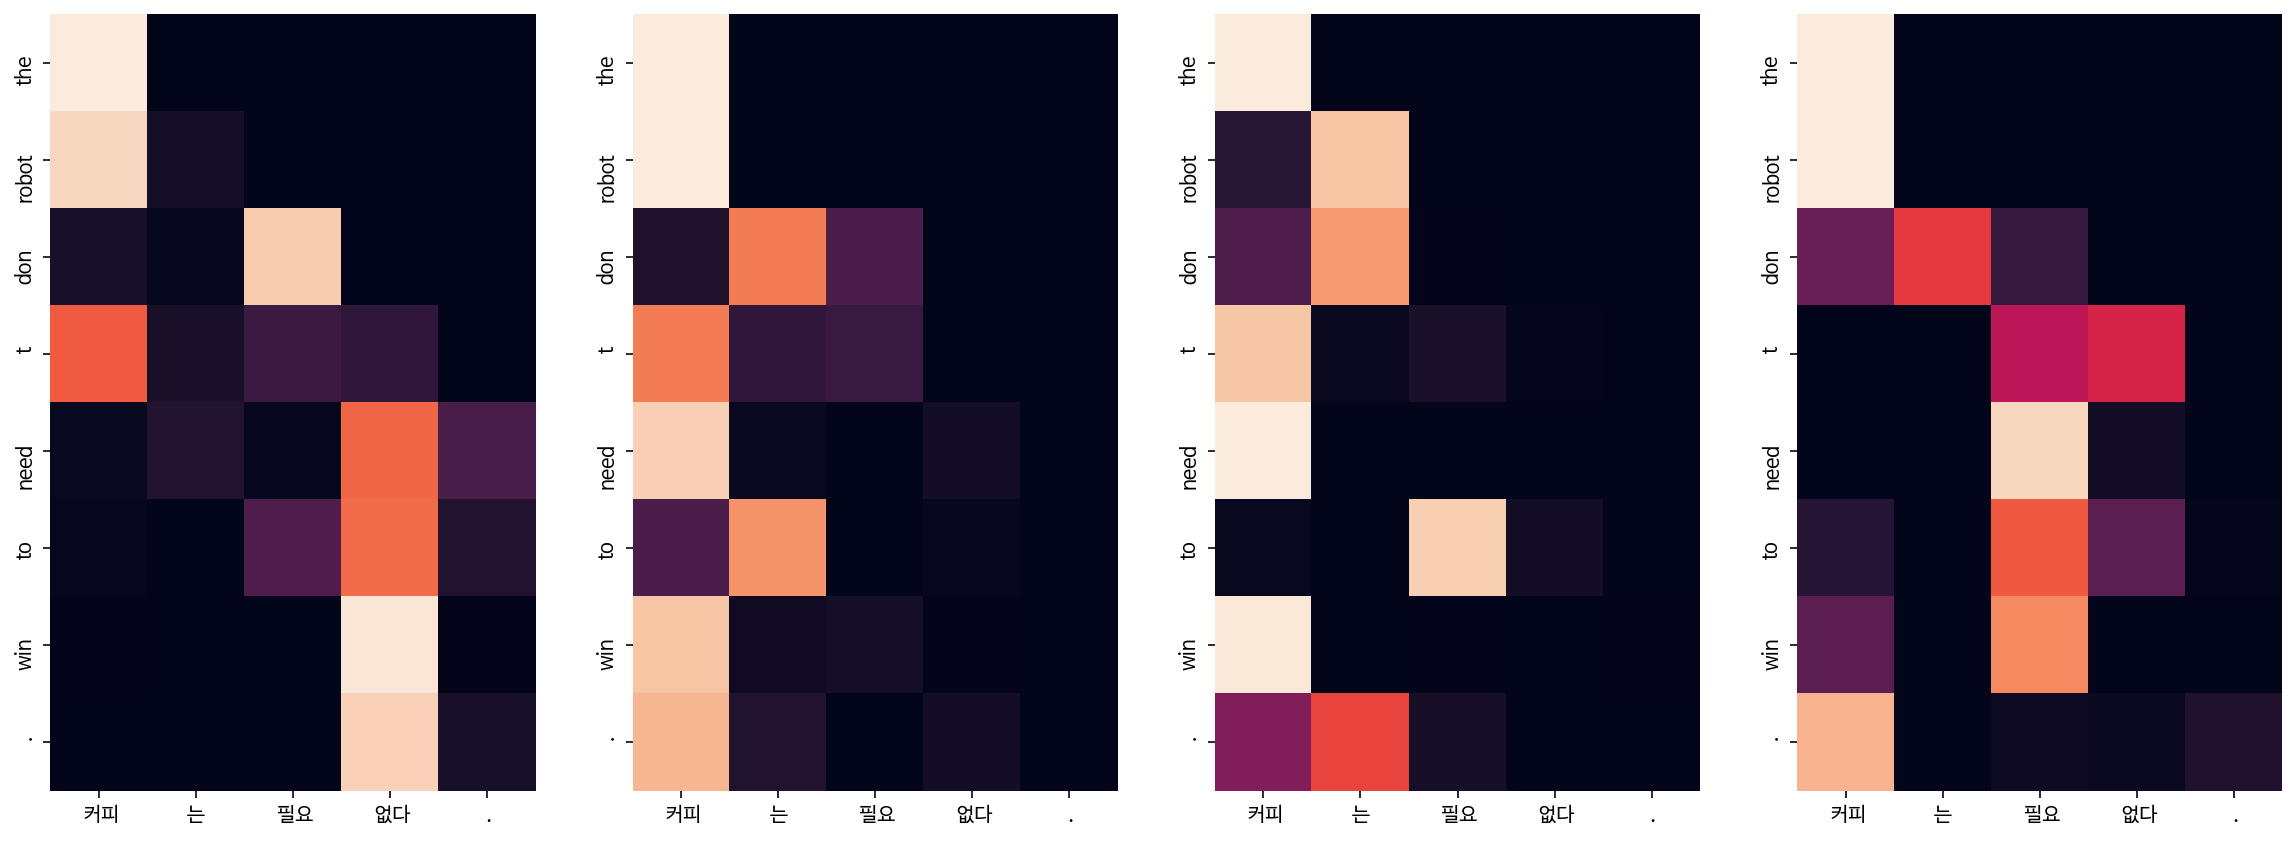

Decoder Self Layer 2


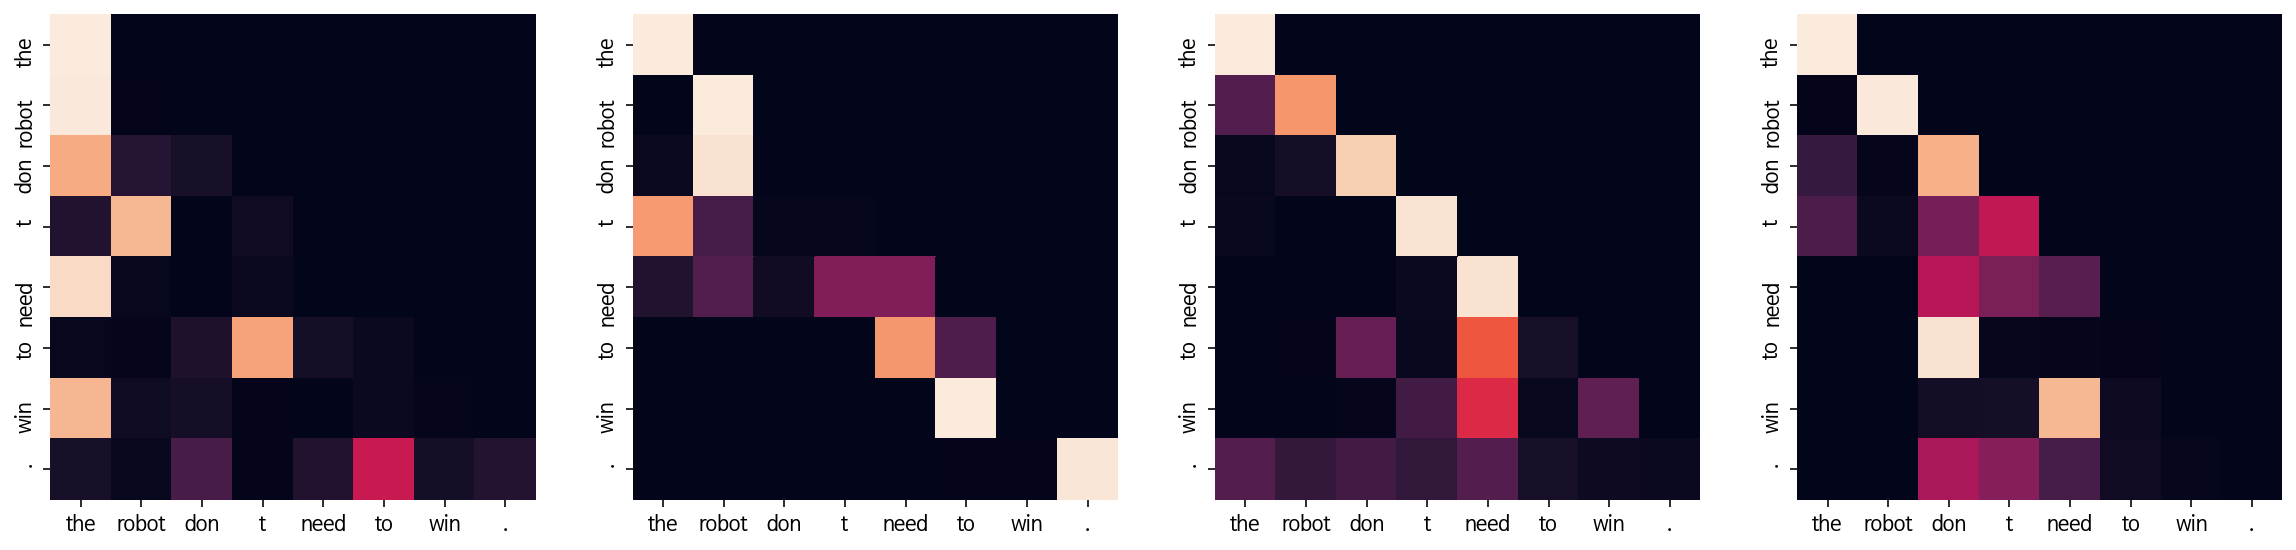

Decoder Src Layer 2


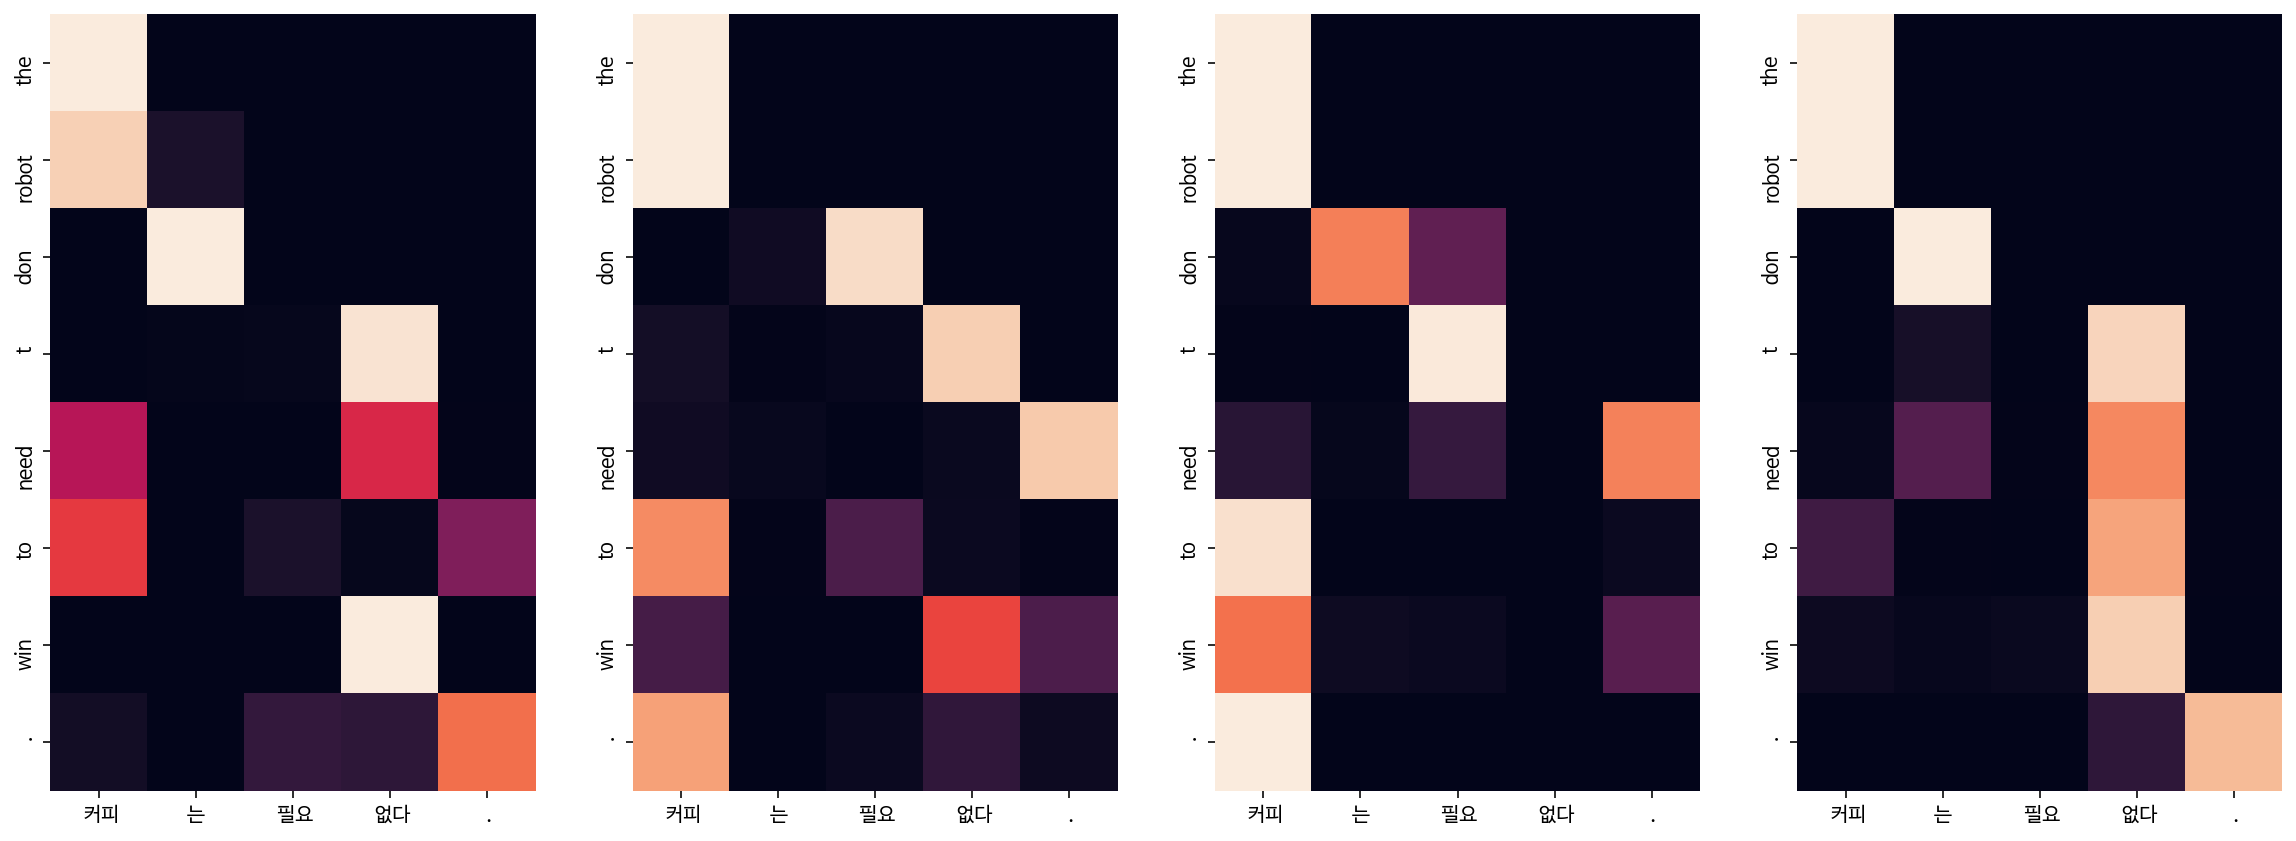

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven seven people died and seven seven seven seven seven texas provinces remained seven seven people .
Encoder Layer 1


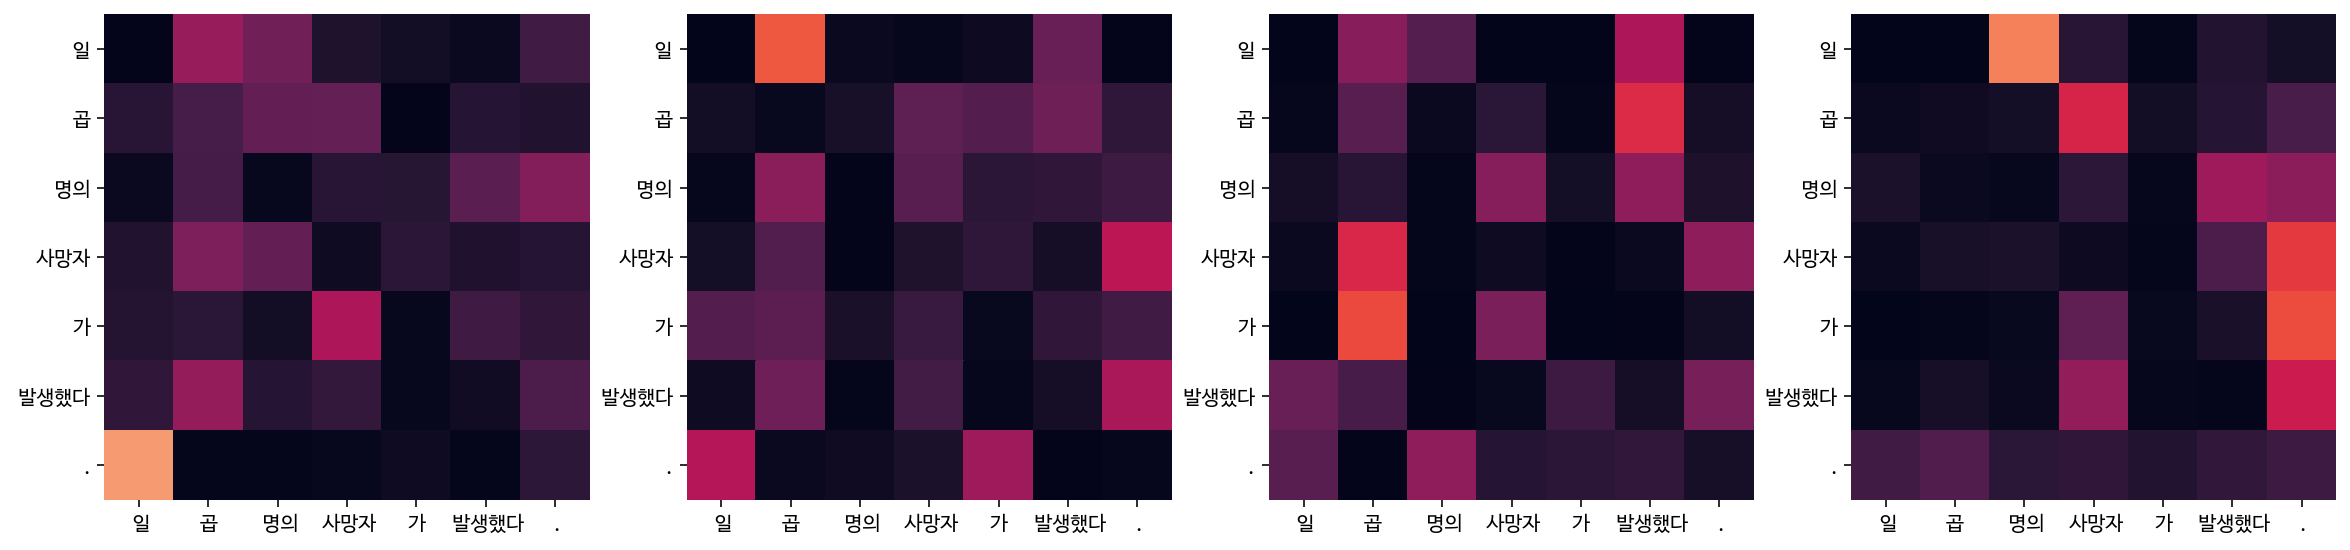

Encoder Layer 2


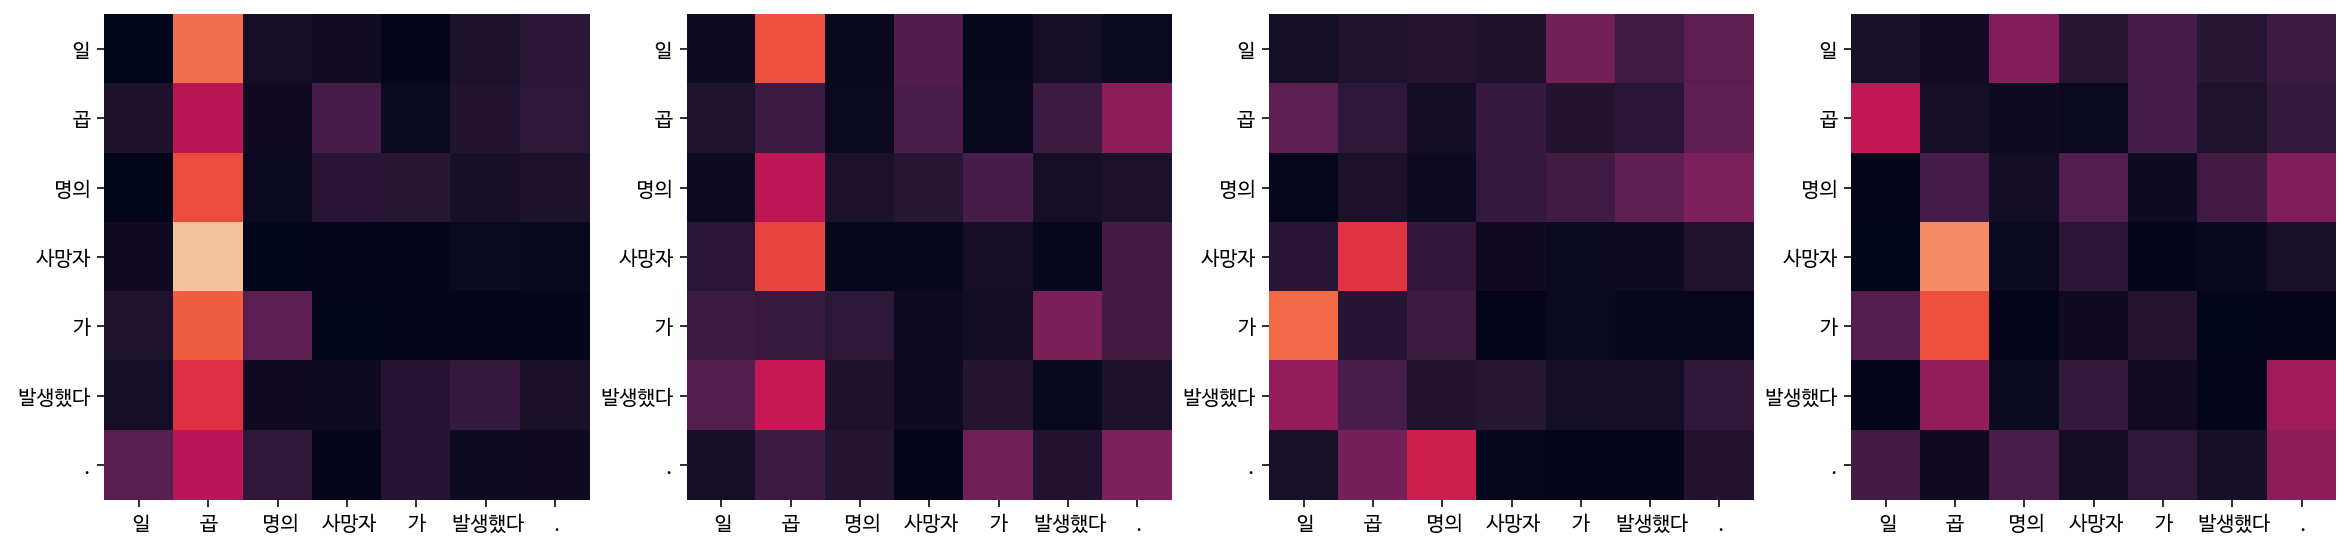

Decoder Self Layer 1


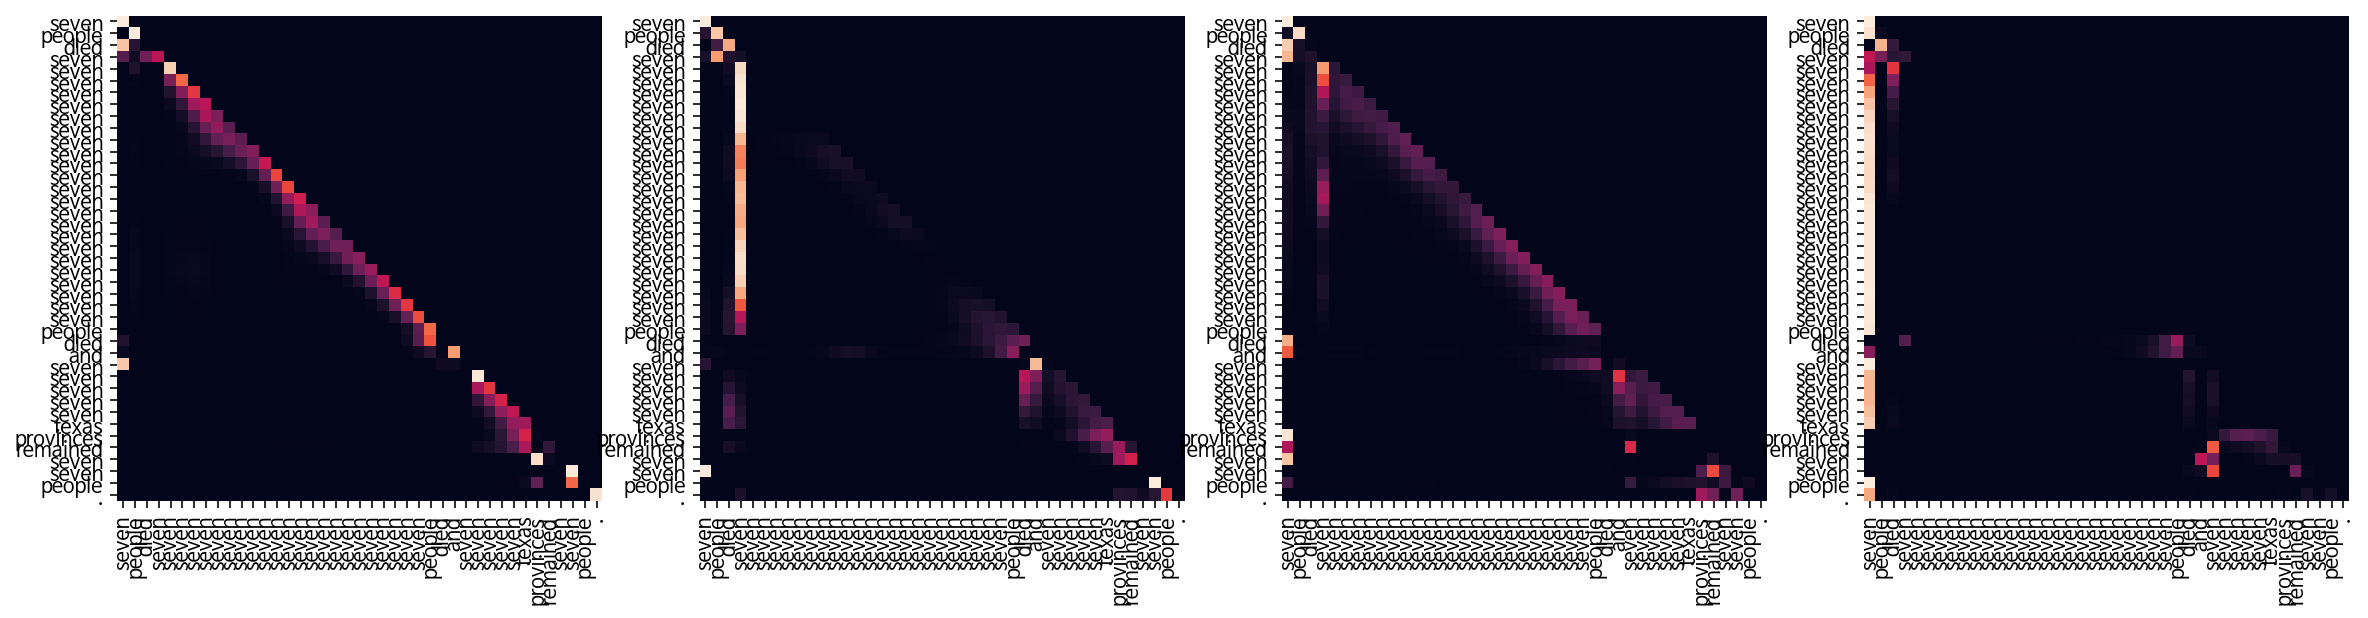

Decoder Src Layer 1


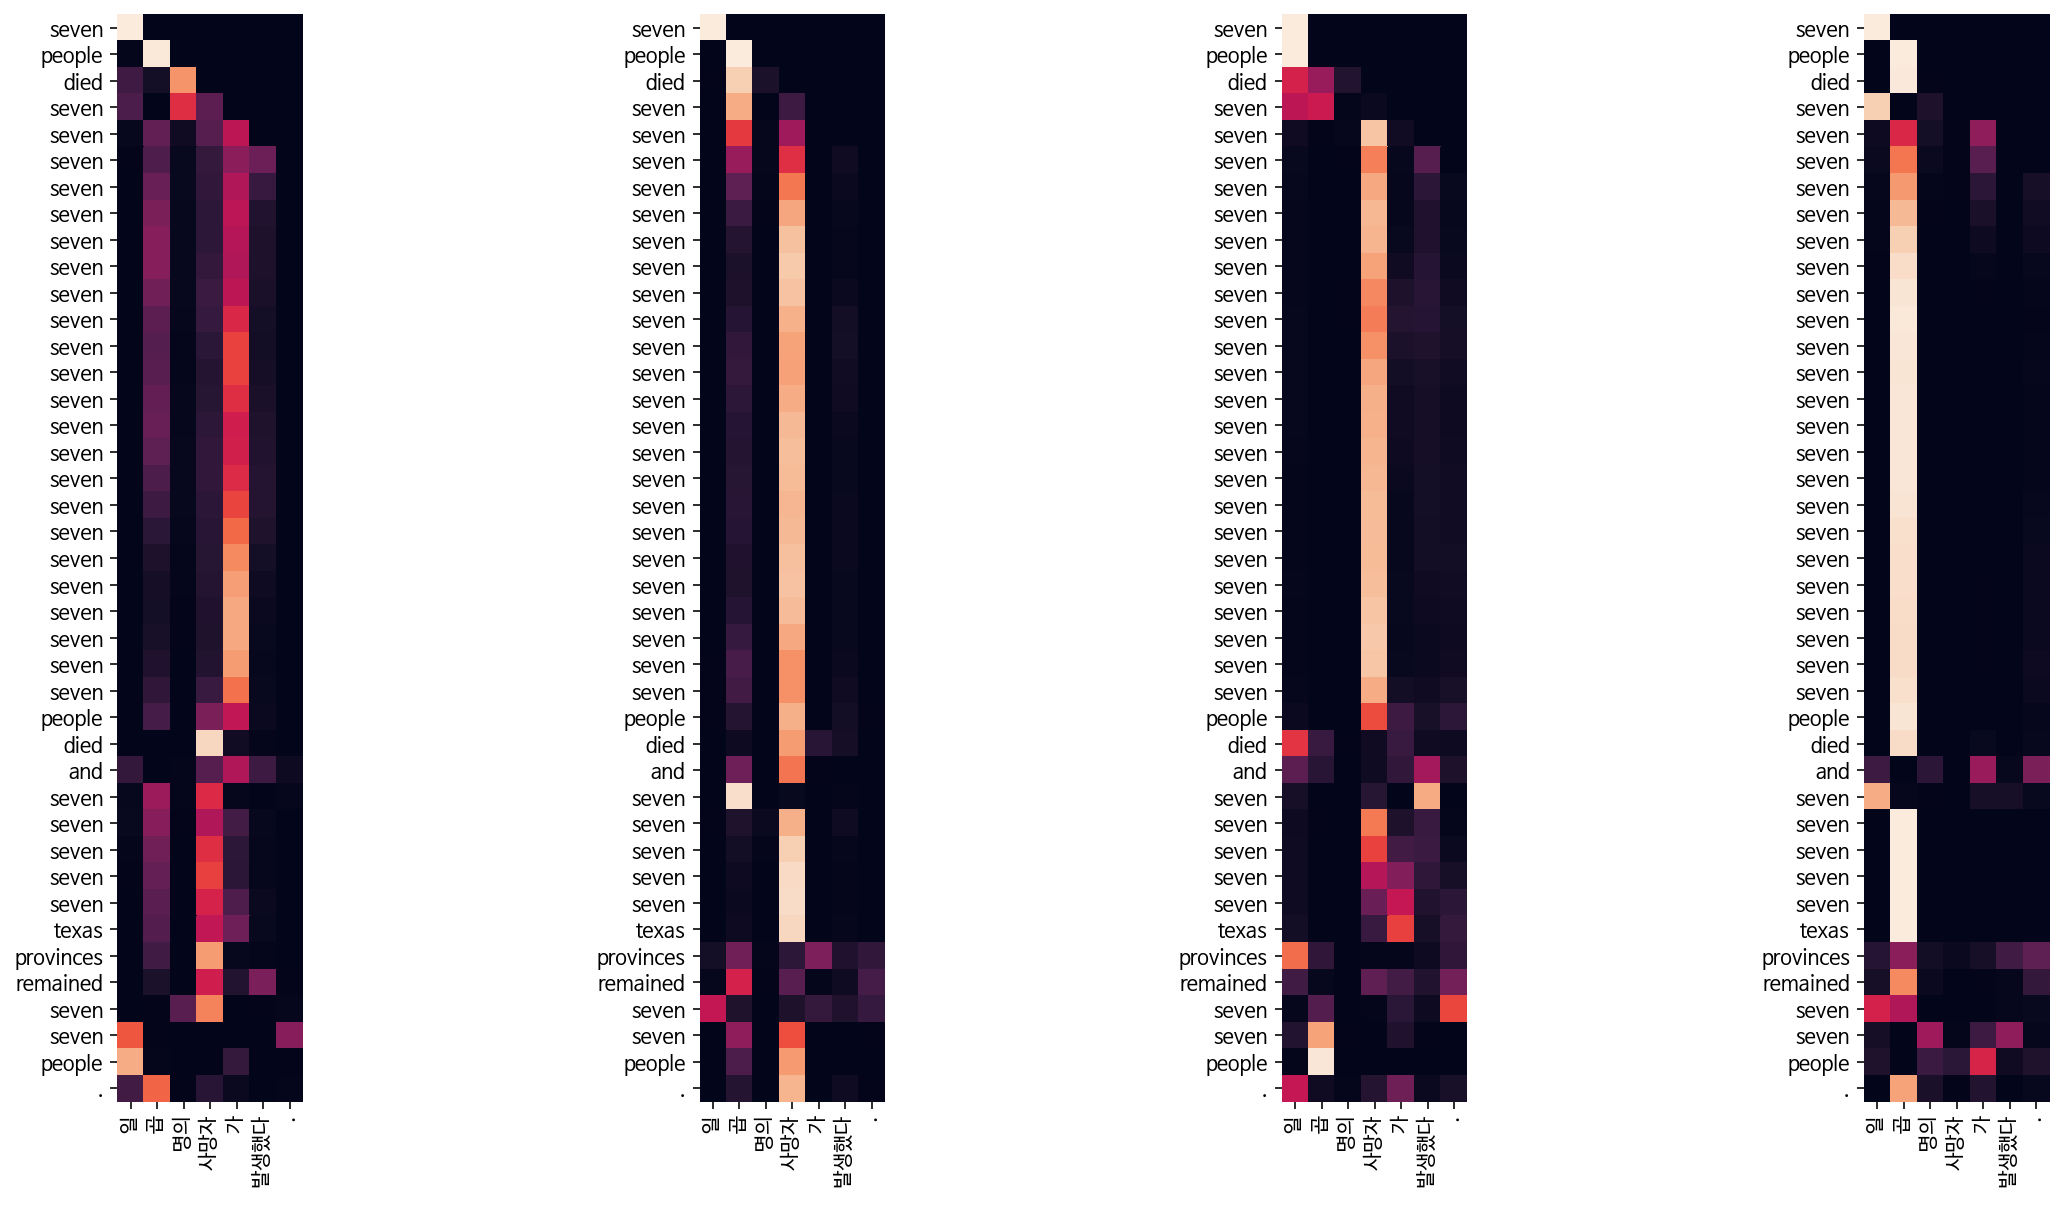

Decoder Self Layer 2


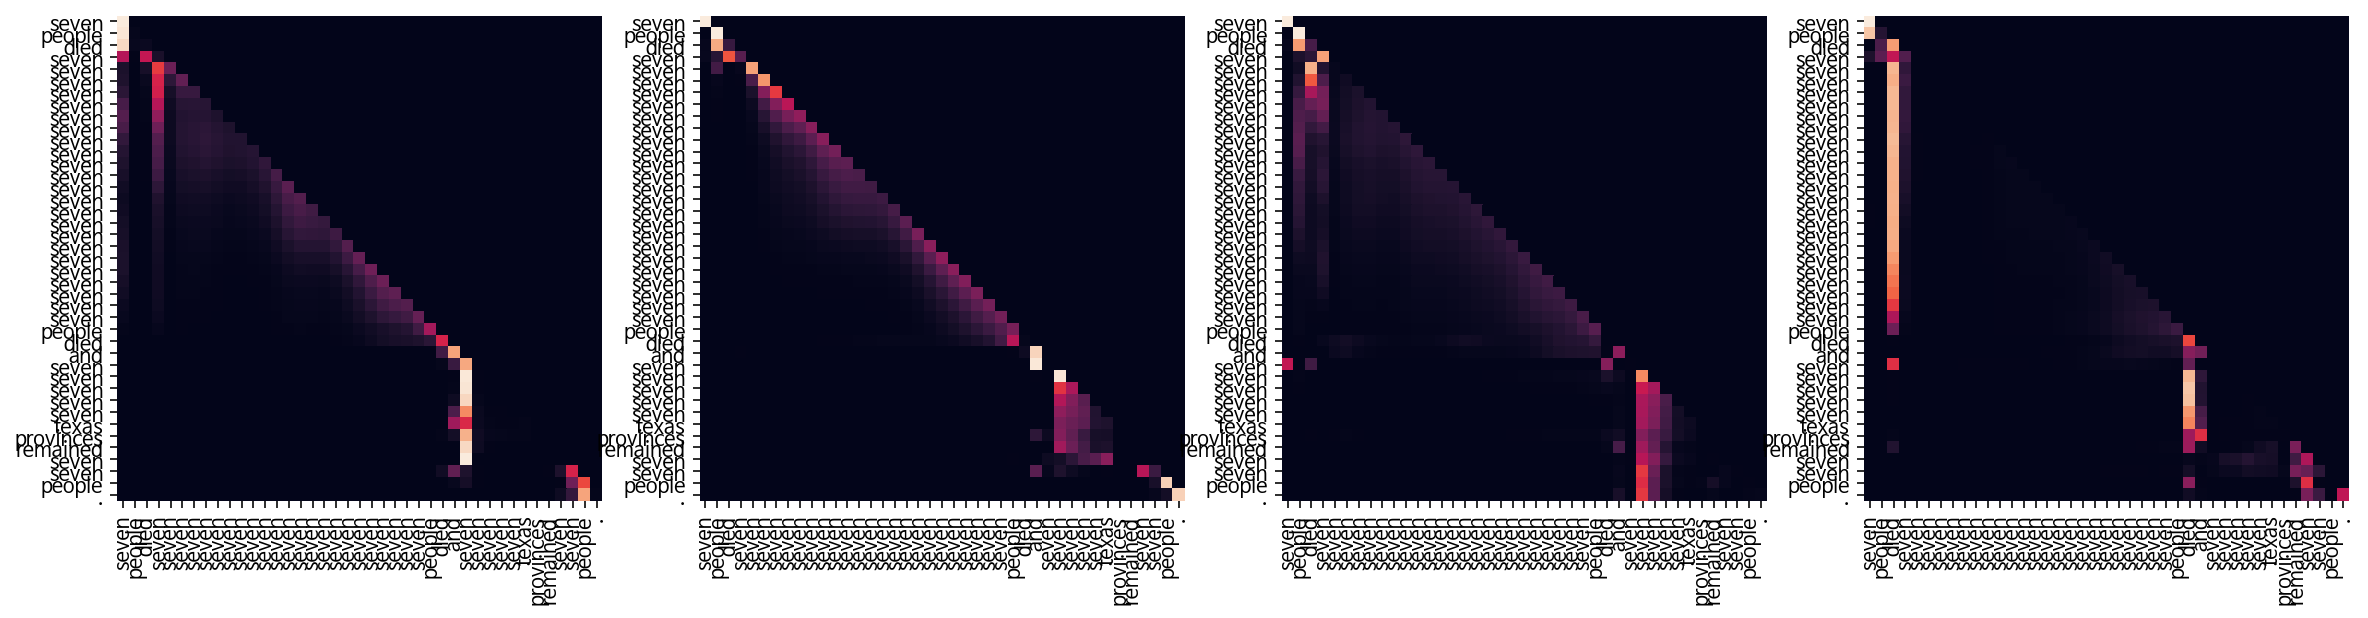

Decoder Src Layer 2


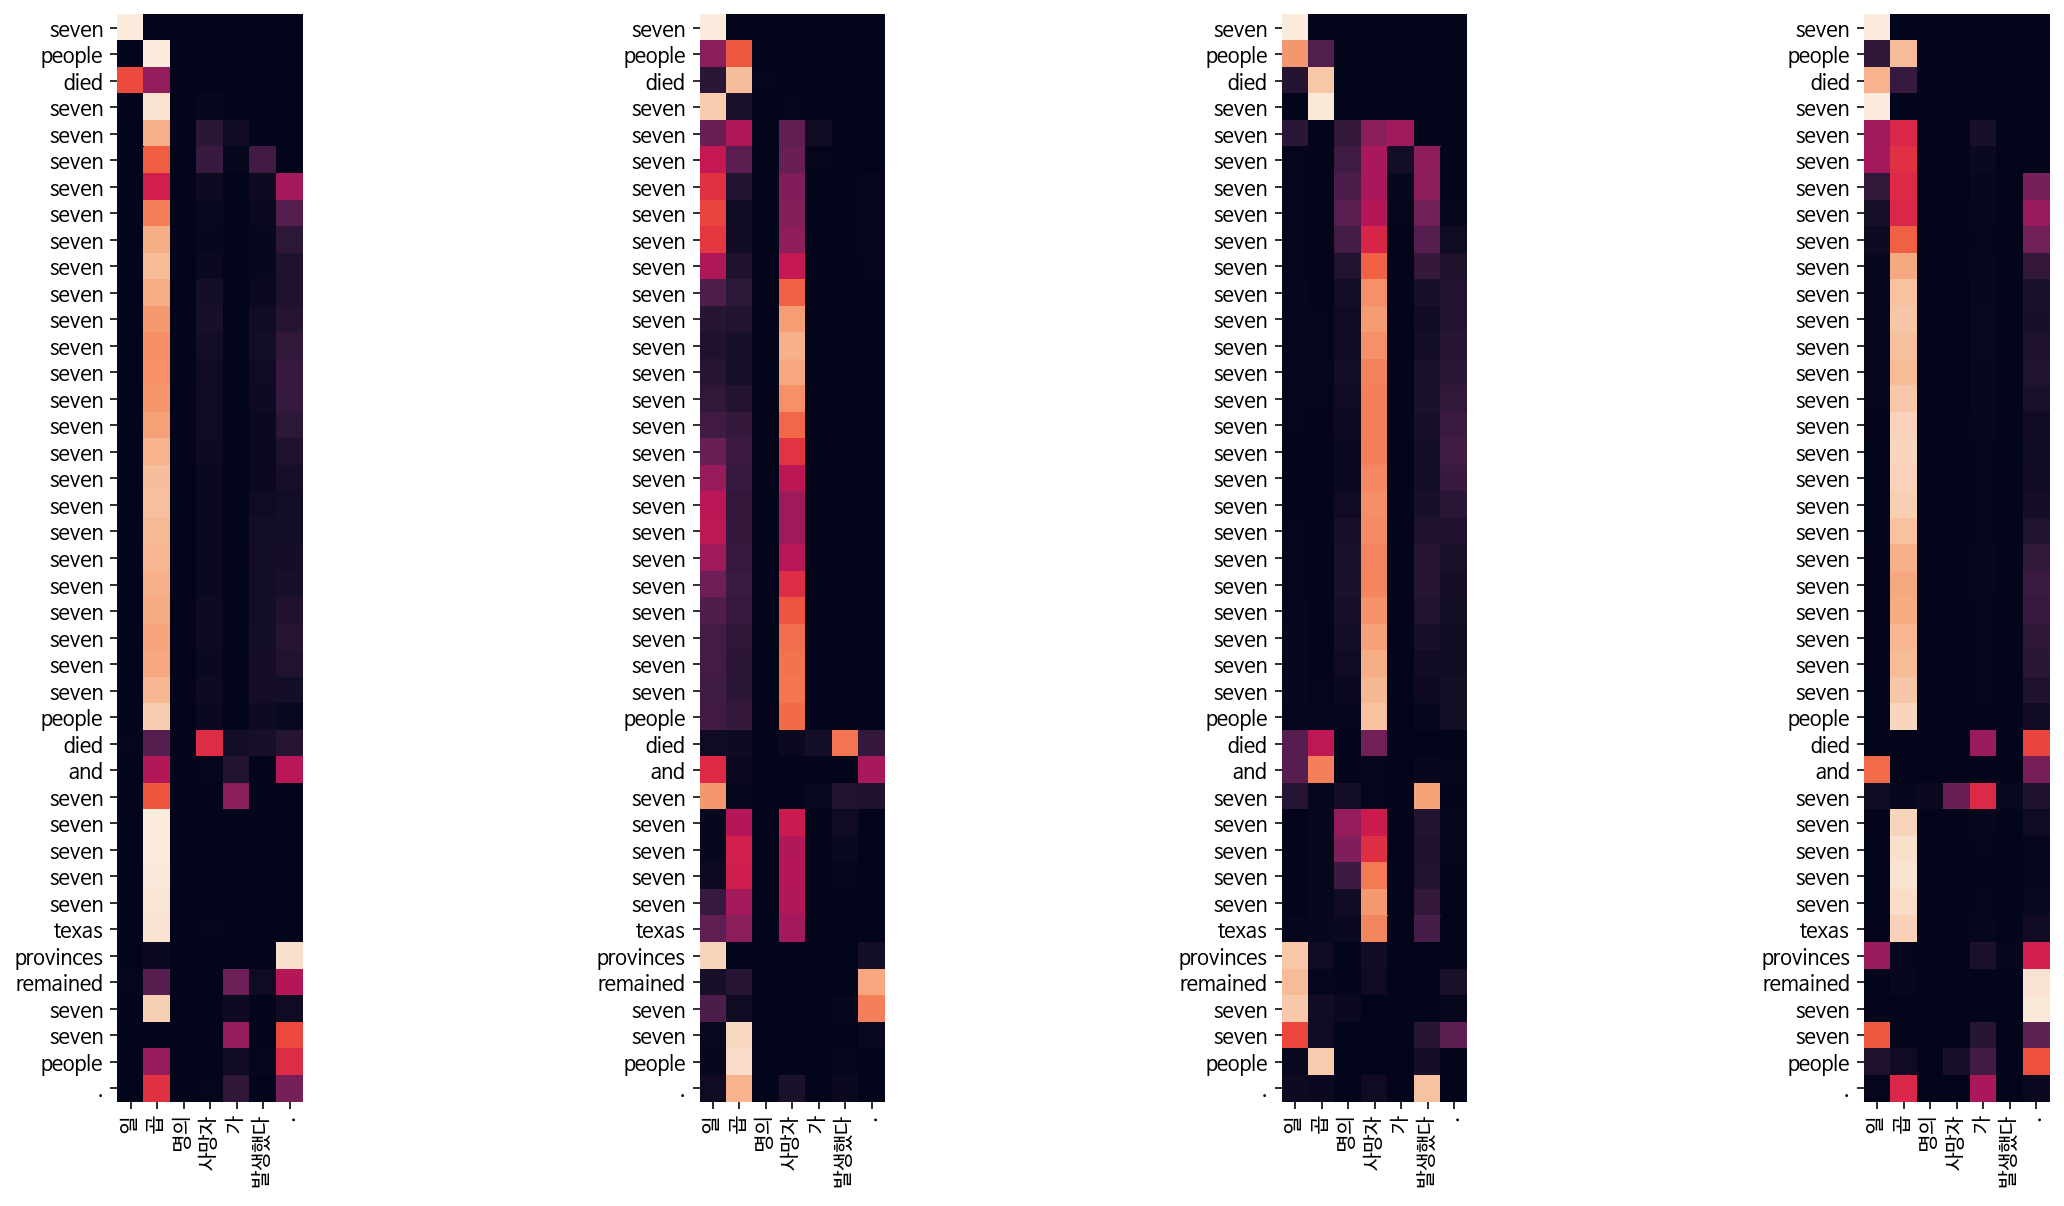

In [31]:
for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer, True)

### 2번째 학습

In [ ]:
# transformer2 = Transformer(
#     n_layers=6,
#     d_model=512,
#     n_heads=8,
#     d_ff=2048,
#     src_vocab_size=SRC_VOCAB_SIZE,
#     tgt_vocab_size=TGT_VOCAB_SIZE,
#     pos_len=200,
#     dropout=0.2,
#     shared=True
# )

In [ ]:
# EPOCHS = 20
# BATCH_SIZE = 8

# for epoch in range(EPOCHS):
#     total_loss = 0

#     idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
#     random.shuffle(idx_list)
#     t = tqdm(idx_list)

#     for (batch, idx) in enumerate(t):
#         batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(enc_train[idx:idx+BATCH_SIZE],
#                                                                      dec_train[idx:idx+BATCH_SIZE],
#                                                                      transformer2,
#                                                                      optimizer)

#         total_loss += batch_loss

#         t.set_description_str('Epoch %2d' % (epoch + 1))
#         t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
#     # 매 Epoch 마다 제시된 예문에 대한 번역 생성
#     for example in examples:
#         translate(example, transformer2, ko_tokenizer, en_tokenizer, True)

  0%|          | 0/8507 [00:00<?, ?it/s]